In [743]:
#TO RE-RUN
%reset -f

In [744]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, mutual_info_score, normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV,chi2, f_oneway
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.externals import joblib
from sklearn import cross_validation
from sklearn import preprocessing
from multiprocessing import Pool
from sklearn.svm import SVC

from IPython.display import display, HTML
import logging.config
import pandas as pd
import numpy as np 
import datetime
import csv
import os
import pickle
import sys

sys.path.insert(1, "/home/aegle/projects/myosa/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

### 1.Load train & test data

In [745]:
index = 0

In [746]:
datafilenames = []

datafilenames.append(os.path.join('resources','data_filtered_cl0_short_no_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016.pkl'))

f = file(datafilenames[index],"rb")
df_all = pd.read_pickle(f)
f.close()

codes = df_all.iloc[:,0]
df_all = df_all.iloc[:,1:]
columns= df_all.columns
feat_types = dict([(c,df_all[c].dtype.name) for c in df_all.columns])

df_all["LABEL"] = pd.to_numeric(df_all["LABEL"])

print len(codes)
print df_all.shape
print feat_types
print columns

42
(42, 77)
{'RONCA': 'int64', 'TRAST_MEM': 'int64', 'EUROQOL': 'float64', 'ALCOHOL': 'object', 'ANTICOAG': 'object', 'DISM_DESEO_SEX': 'object', 'FUMA_PAQ_ANY': 'int64', 'CEFALEA': 'int64', 'FUMA': 'object', 'OBSTR_NASAL_CRON': 'object', 'MEDIA_TAS': 'float64', 'SUE_REP': 'int64', 'CIRUGIA_ORL': 'object', 'TIEMP_SUENO': 'float64', 'CIRC_CUELLO': 'int64', 'NICTURIA': 'float64', 'OTROS_HIPOT': 'object', 'HIPOLIPEM': 'object', 'IAH': 'float64', 'Sat O2': 'int64', 'MOV_BRUSC_INV_DUERME': 'object', 'CA-ANTAG': 'object', 'ANTIAGREG': 'object', 'JUBILADO': 'object', 'DIURETICOS': 'object', 'TRAST_CONC': 'int64', 'CIRC_CADERA': 'int64', 'EPWORTH': 'float64', 'OTROS_PSICO': 'object', 'VISUAL': 'int64', 'ACT_MOTR_NOCT': 'object', 'TIEMPOSAT<90%': 'float64', 'TALLA': 'float64', 'ENF_RESP': 'object', 'IRR_APAT_DEPR': 'int64', 'CRISIS_ASF': 'int64', 'FUMA_EX_ANYS': 'float64', 'DOLOR_PIER_MOVER': 'object', 'CAFES_DIA': 'float64', 'INSOMNIO': 'object', 'GENERO': 'object', 'ANTIDEPRE': 'object', 'IEC

In [747]:
mapCols = dict()
mapCols["GENERO"] = ["GENDER", "Gender","'female':0, 'male':1","CAT", "CLINICAL_HISTORY", "M0"]
mapCols["ACTIVO"] = ["ACTIVE", "Active","'no':0, 'yes':1", "CAT", "CLINICAL_HISTORY", "M0"]
mapCols["NO_ACTIVO"] = ["NO_ACTIVE", "No active","'no':0, 'yes':1", "CAT", "CLINICAL_HISTORY", "M0"]
mapCols["JUBILADO"] = ["RETIRED", "Retired","'no':0, 'yes':1", "CAT", "CLINICAL_HISTORY", "M0"]
mapCols["EDAD"] = ["AGE","Age", "","NUM","CLINICAL_HISTORY", "M0"]
mapCols["FUMA"] = ["SMOKER","Smoker", "'no':0, 'yes':1","CAT","CLINICAL_HISTORY", "M0"]

mapCols["FUMA_PAQ_ANY"] = ["SMOKE_PACK_YEAR","Number of packs of cigarretes smoked a year", "","NUM","CLINICAL_HISTORY", "M0"]
mapCols["FUMA_EX_ANYS"] = ["SMOKE_EX_YEAR","Number of years being ex-smoker", "", "NUM", "CLINICAL_HISTORY","M0"]
mapCols["ALCOHOL"] = ["ALCOHOL","Alcohol intake", "'no':0, 'yes':1","CAT","CLINICAL_HISTORY", "M0"]
mapCols["ALCOHOL_GR_DIA"] = ["ALCOHOL_GR_DAY", "Number of grames of alcohol consumed a day","", "NUM","CLINICAL_HISTORY", "M0"]

mapCols["CAFES_DIA"] = ["CAFES_DAY", "Number of cafes taken a day", "", "NUM", "CLINICAL_HISTORY", "M0"]
mapCols["DEPRESION"] = ["DEPRESSION", "Depression", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["ANSIEDAD"] = ["ANXIETY", "Anxiety", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["HTA"] = ["HTA", "Arterial Hypertension ", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["CARDIOPATIA"] = ["CARDIOPATHY", "Cardiopathy", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]

mapCols["ENF_NEUR"] = ["NEUR_DIS", "Neurological disease", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["ENF_RESP"] = ["RESP_DIS", "Respiratory disease", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["DIABETES"] = ["DIABETES", "Diabetes", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["OBESIDAD"] = ["OBESITY", "Obesity", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["DISLIPEMIA"] = ["DISLIPEMIA", "Suffer dislipemia", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]

mapCols["NEOPLASIA"] = ["NEOPLASIA", "Neoplasia", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["OBSTR_NASAL_CRON"] = ["OBSTR_NASAL_CHRON", "Chronic nasal obstruction", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["CIRUGIA_ORL"] = ["ORAL_SUR", "Oral surgery", "'no':0, 'yes':1", "CAT", "COMORBIDITIES", "M0"]
mapCols["RONCA"] = ["SNORES", "Snores", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["SUE_REP"] = ["REP_SLEEP", "Night repairing sleep", "'never':3, 'sometimes':2, 'frequently':1, 'always':0", "CAT", "SYMPTOMS", "M0"]

mapCols["CRISIS_ASF"] = ["CRISIS_ASP", "Crisis of nocturnal respiratory asphyxia", "'never':0, 'sometimes':1, 'always':2", "CAT", "SYMPTOMS", "M0"]
mapCols["NICTURIA"] = ["NOCTURIA", "Suffer nocturia", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["APNEAS_PRES"] = ["APNEAS_PRES", "Apneas witnessed", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["CEFALEA"] = ["CEFALEA", "Suffer cefaleas", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["SOMN_DIURN"] = ["DAY_SOMN", "Daylight somnolence", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]

mapCols["DESPERTAR_NOCT"] = ["AWAKE_NIGHT", "Night awakening", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["TRAST_MEM"] = ["MEM_DIS", "Memmory disorder", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["TRAST_CONC"] = ["CONC_DIS", "Concentration disorder", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
mapCols["IRR_APAT_DEPR"] = ["IRR_APAT_DEPRE", "Irritibility, apathy, depression", "'never':0, 'sometimes':1, 'frequently':2, 'always':3", "CAT", "SYMPTOMS", "M0"]
    
mapCols["INSOMNIO"] = ["INSOMNIA", "Suffer insomnia", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["ACT_MOTR_NOCT"] = ["ACT_MOTR_NOCT", "Night motor activity", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["DOLOR_PIER_MOVER"] = ["LEG_PAIN_MOVE", "Leg pain with the need to move them ", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]

mapCols["MOV_BRUSC_INV_DUERME"] = ["INV_MOV_SLEEP", "Involuntary brush movements while sleeping", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["SEN_SUE_REAL_DORM"] = ["FEEL_REAL_DRE", "Feeling of having real dreams by sleeping", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["SUE_INT_PIROSIS"] = ["DREAM_INT_PIROSIS", "Dreaming interrupted by pirosis", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]

mapCols["FROTA_DIENT_DUERM"] = ["FLEE_TEETH_SLEEP", "Flee (rechinate) the teeth while sleeping", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["DISM_DESEO_SEX"] = ["DEC_SEX_DIS", "Decrease of desire or sexual power", "'no':0, 'yes':1", "CAT", "SYMPTOMS", "M0"]
mapCols["IECAS"] = ["IECAS", "Iecas intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["BBLOQ"] = ["BBLOQ", "Bbloq intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
        
mapCols["DIURETICOS"] = ["DIURETICS", "Diuretics intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["CA-ANTAG"] = ["CA-ANTAG", "CA-antag intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["ARA-II"] = ["ARA-II", "ara-II intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["ANTIAGREG"] = ["ANTIAGREG", "Antiagregant intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["ANTICOAG"] = ["ANTICOAG", "Anticoagulant intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]

mapCols["ANTIACID"] = ["ANTIACID", "Antiacid intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["BRONCODIL"] = ["BRONCODIL", "Broncodilator intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["ADO"] = ["ADO", "Adenosine intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["INSULINA"] = ["INSULIN", "Insuline intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["HIPOLIPEM"] = ["HIPOLIPEM", "Hipolipemizant intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["BDZ"] = ["BDZ", "Benzodiazepina intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]

mapCols["ANTIDEPRE"] = ["ANTIDEPRE", "Anti-depressive intake", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["OTROS_PSICO"] = ["OTHER_PSICO", "Other drugs type psico", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["OTROS_HIPOT"] = ["OTHER_HIPOT", "Other drugs type hipot", "'no':0, 'yes':1", "CAT", "THERAPY", "M0"]
mapCols["TIEMP_SUENO"] = ["SLEEP_TIME","Total time sleeping", "", "NUM", "SLEEP_TEST", "M0"]
mapCols["IAH"] = ["IAH", "Index apnea hypo-apnea", "", "NUM", "SLEEP_TEST", "M0"]

mapCols["TIEMPOSAT<90%"] = ["TIME_SAT<90%", "Time of saturation <90%", "", "NUM", "SLEEP_TEST", "M0"]
mapCols["CT90%"] = ["CT90%", "Time with oxygen saturation <90%", "", "NUM", "SLEEP_TEST", "M0"]
mapCols["IND_DESAT"] = ["IND_DESAT", "Index of desaturation", "", "NUM", "SLEEP_TEST", "M0"]
mapCols["PESO"] = ["WEIGHT", "Basal weight", "", "NUM", "BASAL", "M0"]
mapCols["TALLA"] = ["SIZE", "Basal size", "", "NUM", "BASAL", "M0"]
mapCols["IMC"] = ["BMI", "Body mass index", "", "NUM", "BASAL", "M0"]

mapCols["CIRC_CUELLO"] = ["CIRC_NECK", "Size of the circumference around the neck", "", "NUM", "BASAL", "M0"]
mapCols["CIRC_ABD"] = ["CIRC_ABD", "Size of the circumference around the abdomen", "", "NUM", "BASAL", "M0"]
mapCols["CIRC_CADERA"] = ["CIRC_HIP", "Size of the circumference around the hip", "", "NUM", "BASAL", "M0"]
mapCols["MEDIA_TAS"] = ["TAS_MEAN", "Systolic blood pressure", "", "NUM", "BASAL", "M0"]
mapCols["MEDIA_TAD"] = ["TAD_MEAN", "Diastolic blood pressure", "", "NUM", "BASAL", "M0"]

mapCols["Sat O2"] = ["SAT_O2", "Quantity of O2 saturation", "", "NUM", "BASAL", "M0"]
mapCols["PRESS_CPAP"] = ["PRESS_CPAP", "CPAP threapy pressure", "", "NUM", "BASAL", "M0"]
mapCols["EPWORTH"] = ["EPWORTH", "Questionnaire result of daytime sleepiness", "[0-24]", "NUM", "BASAL", "M0"]
mapCols["EUROQOL"] = ["EUROQOL", "Questionnaire result for measuring generic health status", "[0-1]", "NUM", "BASAL", "M0"]
mapCols["VISUAL"] = ["VISUAL", "Visual Analog Scale (VAS)", "[0-100]", "NUM", "BASAL", "M0"]
mapCols["LABEL"] = ["LABEL", "Whether or not the person is compliant with CPAP therapy", "'Non-compliant':0, 'Compliant':1 ", "CAT", "LABEL", "M0"]

pd.set_option("max_r",120)
pd.set_option('display.max_colwidth', -1)

dfFeatures = pd.DataFrame(mapCols.values(), columns=["Name","Description","Values","Type","Cat","Month"], index=mapCols.keys())
print dfFeatures.shape

for cat in dfFeatures.Cat.unique():
    display(HTML(dfFeatures[dfFeatures.Cat == cat].sort_values(["Month","Cat","Name"]).to_html(index=False)))

(77, 6)


Name,Description,Values,Type,Cat,Month
ACT_MOTR_NOCT,Night motor activity,"'no':0, 'yes':1",CAT,SYMPTOMS,M0
APNEAS_PRES,Apneas witnessed,"'never':0, 'sometimes':1, 'frequently':2, 'always':3",CAT,SYMPTOMS,M0
AWAKE_NIGHT,Night awakening,"'never':0, 'sometimes':1, 'frequently':2, 'always':3",CAT,SYMPTOMS,M0
CEFALEA,Suffer cefaleas,"'never':0, 'sometimes':1, 'frequently':2, 'always':3",CAT,SYMPTOMS,M0
CONC_DIS,Concentration disorder,"'never':0, 'sometimes':1, 'frequently':2, 'always':3",CAT,SYMPTOMS,M0
CRISIS_ASP,Crisis of nocturnal respiratory asphyxia,"'never':0, 'sometimes':1, 'always':2",CAT,SYMPTOMS,M0
DAY_SOMN,Daylight somnolence,"'never':0, 'sometimes':1, 'frequently':2, 'always':3",CAT,SYMPTOMS,M0
DEC_SEX_DIS,Decrease of desire or sexual power,"'no':0, 'yes':1",CAT,SYMPTOMS,M0
DREAM_INT_PIROSIS,Dreaming interrupted by pirosis,"'no':0, 'yes':1",CAT,SYMPTOMS,M0
FEEL_REAL_DRE,Feeling of having real dreams by sleeping,"'no':0, 'yes':1",CAT,SYMPTOMS,M0


Name,Description,Values,Type,Cat,Month
BMI,Body mass index,,NUM,BASAL,M0
CIRC_ABD,Size of the circumference around the abdomen,,NUM,BASAL,M0
CIRC_HIP,Size of the circumference around the hip,,NUM,BASAL,M0
CIRC_NECK,Size of the circumference around the neck,,NUM,BASAL,M0
EPWORTH,Questionnaire result of daytime sleepiness,[0-24],NUM,BASAL,M0
EUROQOL,Questionnaire result for measuring generic health status,[0-1],NUM,BASAL,M0
PRESS_CPAP,CPAP threapy pressure,,NUM,BASAL,M0
SAT_O2,Quantity of O2 saturation,,NUM,BASAL,M0
SIZE,Basal size,,NUM,BASAL,M0
TAD_MEAN,Diastolic blood pressure,,NUM,BASAL,M0


Name,Description,Values,Type,Cat,Month
ACTIVE,Active,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
AGE,Age,,NUM,CLINICAL_HISTORY,M0
ALCOHOL,Alcohol intake,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
ALCOHOL_GR_DAY,Number of grames of alcohol consumed a day,,NUM,CLINICAL_HISTORY,M0
CAFES_DAY,Number of cafes taken a day,,NUM,CLINICAL_HISTORY,M0
GENDER,Gender,"'female':0, 'male':1",CAT,CLINICAL_HISTORY,M0
NO_ACTIVE,No active,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
RETIRED,Retired,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
SMOKER,Smoker,"'no':0, 'yes':1",CAT,CLINICAL_HISTORY,M0
SMOKE_EX_YEAR,Number of years being ex-smoker,,NUM,CLINICAL_HISTORY,M0


Name,Description,Values,Type,Cat,Month
ADO,Adenosine intake,"'no':0, 'yes':1",CAT,THERAPY,M0
ANTIACID,Antiacid intake,"'no':0, 'yes':1",CAT,THERAPY,M0
ANTIAGREG,Antiagregant intake,"'no':0, 'yes':1",CAT,THERAPY,M0
ANTICOAG,Anticoagulant intake,"'no':0, 'yes':1",CAT,THERAPY,M0
ANTIDEPRE,Anti-depressive intake,"'no':0, 'yes':1",CAT,THERAPY,M0
ARA-II,ara-II intake,"'no':0, 'yes':1",CAT,THERAPY,M0
BBLOQ,Bbloq intake,"'no':0, 'yes':1",CAT,THERAPY,M0
BDZ,Benzodiazepina intake,"'no':0, 'yes':1",CAT,THERAPY,M0
BRONCODIL,Broncodilator intake,"'no':0, 'yes':1",CAT,THERAPY,M0
CA-ANTAG,CA-antag intake,"'no':0, 'yes':1",CAT,THERAPY,M0


Name,Description,Values,Type,Cat,Month
ANXIETY,Anxiety,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
CARDIOPATHY,Cardiopathy,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
DEPRESSION,Depression,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
DIABETES,Diabetes,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
DISLIPEMIA,Suffer dislipemia,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
HTA,Arterial Hypertension,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
NEOPLASIA,Neoplasia,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
NEUR_DIS,Neurological disease,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
OBESITY,Obesity,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0
OBSTR_NASAL_CHRON,Chronic nasal obstruction,"'no':0, 'yes':1",CAT,COMORBIDITIES,M0


Name,Description,Values,Type,Cat,Month
CT90%,Time with oxygen saturation <90%,,NUM,SLEEP_TEST,M0
IAH,Index apnea hypo-apnea,,NUM,SLEEP_TEST,M0
IND_DESAT,Index of desaturation,,NUM,SLEEP_TEST,M0
SLEEP_TIME,Total time sleeping,,NUM,SLEEP_TEST,M0
TIME_SAT<90%,Time of saturation <90%,,NUM,SLEEP_TEST,M0


Name,Description,Values,Type,Cat,Month
LABEL,Whether or not the person is compliant with CPAP therapy,"'Non-compliant':0, 'Compliant':1",CAT,LABEL,M0


In [748]:
print df_all.columns
print dfFeatures.ix[df_all.columns].Name.tolist()

df_all.columns = dfFeatures.ix[df_all.columns].Name.tolist()
columns= df_all.columns
feat_types = dict([(c,df_all[c].dtype.name) for c in df_all.columns])

Index([u'GENERO', u'ACTIVO', u'NO_ACTIVO', u'JUBILADO', u'EDAD', u'FUMA',
       u'FUMA_PAQ_ANY', u'FUMA_EX_ANYS', u'ALCOHOL', u'ALCOHOL_GR_DIA',
       u'CAFES_DIA', u'DEPRESION', u'ANSIEDAD', u'HTA', u'CARDIOPATIA',
       u'ENF_NEUR', u'ENF_RESP', u'DIABETES', u'OBESIDAD', u'DISLIPEMIA',
       u'NEOPLASIA', u'OBSTR_NASAL_CRON', u'CIRUGIA_ORL', u'RONCA', u'SUE_REP',
       u'CRISIS_ASF', u'NICTURIA', u'APNEAS_PRES', u'CEFALEA', u'SOMN_DIURN',
       u'DESPERTAR_NOCT', u'TRAST_MEM', u'TRAST_CONC', u'IRR_APAT_DEPR',
       u'INSOMNIO', u'ACT_MOTR_NOCT', u'DOLOR_PIER_MOVER',
       u'MOV_BRUSC_INV_DUERME', u'SEN_SUE_REAL_DORM', u'SUE_INT_PIROSIS',
       u'FROTA_DIENT_DUERM', u'DISM_DESEO_SEX', u'IECAS', u'BBLOQ',
       u'DIURETICOS', u'CA-ANTAG', u'ARA-II', u'ANTIAGREG', u'ANTICOAG',
       u'ANTIACID', u'BRONCODIL', u'ADO', u'INSULINA', u'HIPOLIPEM', u'BDZ',
       u'ANTIDEPRE', u'OTROS_PSICO', u'OTROS_HIPOT', u'TIEMP_SUENO', u'IAH',
       u'TIEMPOSAT<90%', u'CT90%', u'IND_DESAT', 

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


### 2. ALL data exploration & visualization

#### Column types

In [749]:
catCols = []
reducedCols = columns[:-1]

CAT_ES = ["RONCA","SUE_REP","CRISIS_ASF","NICTURIA","APNEAS_PRES","CEFALEA",
                "SOMN_DIURN","DESPERTAR_NOCT","TRAST_MEM","TRAST_CONC","IRR_APAT_DEPR"]
CAT_EN = dfFeatures.ix[CAT_ES].Name.tolist()
print CAT_EN

for i in range(len(columns)-1):

    if feat_types[columns[i]] == 'object' or columns[i] in CAT_EN:
        catCols.append(1)
    else:
        catCols.append(0)
        
catCols = np.array(catCols)

print "\nCat cols:", np.sum(catCols==1)
print "*************"
print columns[:-1][catCols==1]

print "\nNum cols:", np.sum(catCols==0)
print "*************"
print columns[:-1][catCols==0]

print len(reducedCols), type(reducedCols)

['SNORES', 'REP_SLEEP', 'CRISIS_ASP', 'NOCTURIA', 'APNEAS_PRES', 'CEFALEA', 'DAY_SOMN', 'AWAKE_NIGHT', 'MEM_DIS', 'CONC_DIS', 'IRR_APAT_DEPRE']

Cat cols: 53
*************
Index([u'GENDER', u'ACTIVE', u'NO_ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'NEUR_DIS',
       u'RESP_DIS', u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'NEOPLASIA',
       u'OBSTR_NASAL_CHRON', u'ORAL_SUR', u'SNORES', u'REP_SLEEP',
       u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA', u'DAY_SOMN',
       u'AWAKE_NIGHT', u'MEM_DIS', u'CONC_DIS', u'IRR_APAT_DEPRE', u'INSOMNIA',
       u'ACT_MOTR_NOCT', u'LEG_PAIN_MOVE', u'INV_MOV_SLEEP', u'FEEL_REAL_DRE',
       u'DREAM_INT_PIROSIS', u'FLEE_TEETH_SLEEP', u'DEC_SEX_DIS', u'IECAS',
       u'BBLOQ', u'DIURETICS', u'CA-ANTAG', u'ARA-II', u'ANTIAGREG',
       u'ANTICOAG', u'ANTIACID', u'BRONCODIL', u'ADO', u'INSULIN',
       u'HIPOLIPEM', u'BDZ', u'ANTIDEPRE', u'OTHER_PSICO', u'OTHER_HIPOT'],
      dtype='ob

####  Cohort description

Categoric features

In [750]:
catData = []
for rv in df_all.columns[catCols == 1]:

    cleanIc = df_all[rv]
    catData.append([rv,
                    np.sum(cleanIc.isnull() == False),
                    np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                    pd.value_counts(cleanIc).index.astype(int).tolist(), 
                    pd.value_counts(cleanIc).values.tolist(),
                    (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                    pd.value_counts(cleanIc).values.min(),
                    pd.value_counts(cleanIc).values.max(),
                    dfFeatures[dfFeatures["Name"] == rv]["Cat"].values[0]
                    ])
    
dfCatData = pd.DataFrame(catData, columns=["variable","n",u"%nulls","values","frequencies","ratios","min","max", "type"])

display(HTML(dfCatData[dfCatData.type.isin(["CLINICAL_HISTORY","COMORBIDITIES"])].to_html(index=False)))
display(HTML(dfCatData[dfCatData.type.isin(["SYMPTOMS"])].to_html(index=False)))
display(HTML(dfCatData[dfCatData.type.isin(["THERAPY"])].to_html(index=False)))

variable,n,%nulls,values,frequencies,ratios,min,max,type
GENDER,42,0.00,"[1, 0]","[29, 13]","[0.69, 0.31]",13,29,CLINICAL_HISTORY
ACTIVE,42,0.00,"[1, 0]","[25, 17]","[0.6, 0.4]",17,25,CLINICAL_HISTORY
NO_ACTIVE,42,0.00,"[0, 1]","[25, 17]","[0.6, 0.4]",17,25,CLINICAL_HISTORY
RETIRED,42,0.00,"[0, 1]","[28, 14]","[0.67, 0.33]",14,28,CLINICAL_HISTORY
SMOKER,42,0.00,"[0, 1]","[26, 16]","[0.62, 0.38]",16,26,CLINICAL_HISTORY
ALCOHOL,42,0.00,"[0, 1]","[24, 18]","[0.57, 0.43]",18,24,CLINICAL_HISTORY
DEPRESSION,42,0.00,"[0, 1]","[35, 7]","[0.83, 0.17]",7,35,COMORBIDITIES
ANXIETY,42,0.00,"[0, 1]","[33, 9]","[0.79, 0.21]",9,33,COMORBIDITIES
HTA,42,0.00,"[1, 0]","[25, 17]","[0.6, 0.4]",17,25,COMORBIDITIES
CARDIOPATHY,42,0.00,"[0, 1]","[30, 12]","[0.71, 0.29]",12,30,COMORBIDITIES


variable,n,%nulls,values,frequencies,ratios,min,max,type
SNORES,42,0.00,"[3, 2, 1]","[29, 10, 3]","[0.69, 0.24, 0.07]",3,29,SYMPTOMS
REP_SLEEP,42,0.00,"[2, 0, 1, 3]","[19, 11, 7, 5]","[0.45, 0.26, 0.17, 0.12]",5,19,SYMPTOMS
CRISIS_ASP,42,0.00,"[0, 1, 2]","[24, 14, 4]","[0.57, 0.33, 0.1]",4,24,SYMPTOMS
NOCTURIA,41,0.02,"[3, 1, 0, 2]","[15, 12, 9, 5]","[0.37, 0.29, 0.22, 0.12]",5,15,SYMPTOMS
APNEAS_PRES,41,0.02,"[2, 0, 1, 3]","[12, 10, 10, 9]","[0.29, 0.24, 0.24, 0.22]",9,12,SYMPTOMS
CEFALEA,42,0.00,"[0, 1, 3, 2]","[29, 11, 1, 1]","[0.69, 0.26, 0.02, 0.02]",1,29,SYMPTOMS
DAY_SOMN,42,0.00,"[0, 1, 2, 3]","[13, 11, 10, 8]","[0.31, 0.26, 0.24, 0.19]",8,13,SYMPTOMS
AWAKE_NIGHT,42,0.00,"[0, 2, 3, 1]","[21, 11, 5, 5]","[0.5, 0.26, 0.12, 0.12]",5,21,SYMPTOMS
MEM_DIS,42,0.00,"[0, 1, 2]","[27, 9, 6]","[0.64, 0.21, 0.14]",6,27,SYMPTOMS
CONC_DIS,42,0.00,"[0, 1, 2]","[29, 7, 6]","[0.69, 0.17, 0.14]",6,29,SYMPTOMS


variable,n,%nulls,values,frequencies,ratios,min,max,type
IECAS,42,0.00,"[0, 1]","[29, 13]","[0.69, 0.31]",13,29,THERAPY
BBLOQ,42,0.00,"[0, 1]","[38, 4]","[0.9, 0.1]",4,38,THERAPY
DIURETICS,42,0.00,"[0, 1]","[32, 10]","[0.76, 0.24]",10,32,THERAPY
CA-ANTAG,42,0.00,"[0, 1]","[37, 5]","[0.88, 0.12]",5,37,THERAPY
ARA-II,42,0.00,"[0, 1]","[37, 5]","[0.88, 0.12]",5,37,THERAPY
ANTIAGREG,42,0.00,"[0, 1]","[33, 9]","[0.79, 0.21]",9,33,THERAPY
ANTICOAG,42,0.00,"[0, 1]","[37, 5]","[0.88, 0.12]",5,37,THERAPY
ANTIACID,42,0.00,"[0, 1]","[32, 10]","[0.76, 0.24]",10,32,THERAPY
BRONCODIL,42,0.00,"[0, 1]","[37, 5]","[0.88, 0.12]",5,37,THERAPY
ADO,42,0.00,"[0, 1]","[33, 9]","[0.79, 0.21]",9,33,THERAPY


In [751]:
numData = df_all[df_all.columns[catCols == 0]].describe().T.copy()
numData = numData.append(df_all["LABEL"].describe().T)

numData["n"] = numData["count"].astype(int)
numData["variable"] = numData.index.values
numData["#nulls"] = 42 - numData["n"]
numData["%nulls"] = numData["#nulls"] / 42.0

types = []
for v in numData["variable"].values:
    types.append(dfFeatures[dfFeatures["Name"] == v]["Cat"])

numData["type"] = np.array(types)
numData["variable"].replace("LABEL", 'MEAN_USE_HOURS_6',inplace=True)

print numData.shape[0], \
      numData[numData.type.isin(["CLINICAL_HISTORY","BASAL"])].shape[0],\
      numData[np.logical_not(numData.type.isin(["CLINICAL_HISTORY","BASAL"]))].shape[0]

display(HTML(numData
             [["variable","n",u"%nulls","mean","std","min","25%","50%","75%","max","type"]].to_html(index=False)))

24 18 6


variable,n,%nulls,mean,std,min,25%,50%,75%,max,type
AGE,42,0.00,56.93,12.58,33.00,48.00,57.00,65.00,81.00,CLINICAL_HISTORY
SMOKE_PACK_YEAR,42,0.00,152.55,252.88,0.00,0.00,0.00,342.25,"1,095.00",CLINICAL_HISTORY
SMOKE_EX_YEAR,42,0.00,2.70,5.54,0.00,0.00,0.00,1.00,20.00,CLINICAL_HISTORY
ALCOHOL_GR_DAY,42,0.00,4.35,9.25,0.00,0.00,0.00,5.00,40.00,CLINICAL_HISTORY
CAFES_DAY,42,0.00,1.36,1.30,0.00,0.00,1.00,2.00,5.00,CLINICAL_HISTORY
SLEEP_TIME,41,0.02,389.76,74.49,173.00,347.00,394.00,453.00,500.00,SLEEP_TEST
IAH,42,0.00,53.13,20.97,15.50,37.19,52.95,65.60,94.50,SLEEP_TEST
TIME_SAT<90%,42,0.00,65.30,75.58,0.90,14.00,31.50,92.41,299.20,SLEEP_TEST
CT90%,42,0.00,19.82,23.07,0.80,4.00,8.00,29.75,92.00,SLEEP_TEST
IND_DESAT,42,0.00,39.33,25.41,1.97,19.79,34.60,61.32,90.70,SLEEP_TEST


#### Impute NaN

,%_Null,#_Null
APNEAS_PRES,0.02,1
DEC_SEX_DIS,0.10,4
FLEE_TEETH_SLEEP,0.02,1
INV_MOV_SLEEP,0.02,1
NEUR_DIS,0.02,1
NOCTURIA,0.02,1
OBSTR_NASAL_CHRON,0.02,1
ORAL_SUR,0.05,2
OTHER_HIPOT,0.07,3
OTHER_PSICO,0.07,3


(11, 2)


<function matplotlib.pyplot.show>

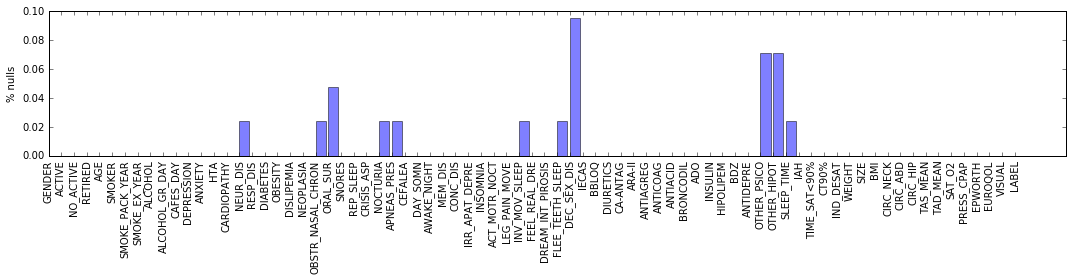

In [752]:
dfNull = np.sum(df_all.isnull()) / float(df_all.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df_all.isnull())], axis=1)
dfNullAll.columns= ["%_Null","#_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(15,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:], alpha=0.5)
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

In [753]:
#Transform discrete
imputer = TypeFeatImputer(catCols, reducedCols)
imputer.fit(df_all.iloc[:,:-1].values.astype(float),df_all.iloc[:,-1].values.astype(float))

dfImputed = imputer.transform(df_all.iloc[:,:-1].values.astype(float))
dfImputed = pd.DataFrame(dfImputed,columns=df_all.columns[:-1])

print "Total NaN after imputation:", np.sum(np.sum(np.isnan(dfImputed.astype(float))))
print "Total NaN:", np.sum(np.isnan(df_all.values.astype(float)))

Total NaN after imputation: 0
Total NaN: 19


#### Numeric feaures: Normality test

In [754]:
import scipy.stats as stats

arrNorm = []
for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if catCols[i] == 1 else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

display(HTML(dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]].to_html(index=False)))

(76, 5)
Normal features: 18
Normal numerical features: 15
Normal categorical features: 3
No Normal features: 58
No Normal numerical features: 8
No Normal categorical features: 50


variable,f_val,p_value,norm
AGE,1.494,0.4738,yes
SMOKE_PACK_YEAR,26.8084,0.0,no
SMOKE_EX_YEAR,26.2396,0.0,no
ALCOHOL_GR_DAY,46.7598,0.0,no
CAFES_DAY,5.0779,0.0789,yes
SLEEP_TIME,5.6497,0.0593,yes
IAH,3.3132,0.1908,yes
TIME_SAT<90%,20.0034,0.0,no
CT90%,22.1006,0.0,no
IND_DESAT,7.0876,0.0289,no


#### Distribution Numeric features

AGE
Unique values: 29
p-value: 0.473779508033
Normal: True
Mean: 56.9285714286 std: 12.4257659669


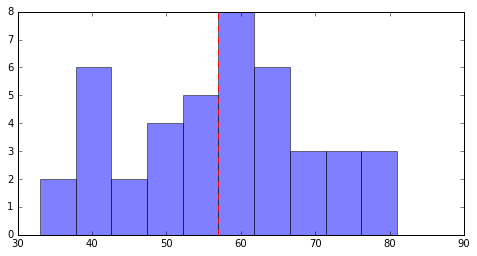

SMOKE_PACK_YEAR
Unique values: 11
p-value: 1.50879486303e-06
Normal: False
Mean: 152.547619048 std: 249.854167216


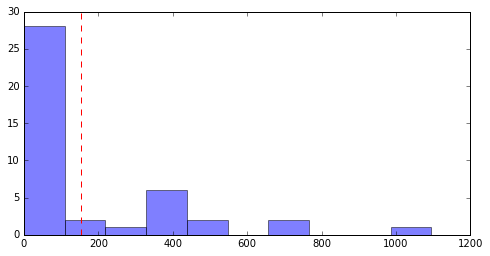

SMOKE_EX_YEAR
Unique values: 12
p-value: 2.00515958455e-06
Normal: False
Mean: 2.69642857143 std: 5.47220675493


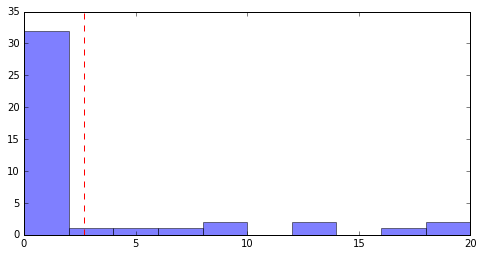

ALCOHOL_GR_DAY
Unique values: 8
p-value: 7.01827283906e-11
Normal: False
Mean: 4.34666666667 std: 9.13975894927


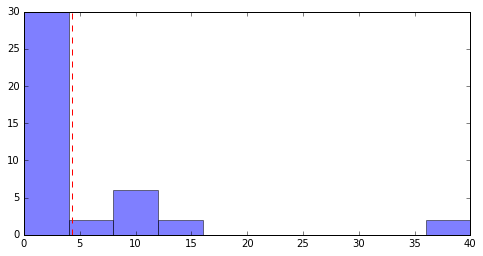

CAFES_DAY
Unique values: 7
p-value: 0.0789482447932
Normal: True
Mean: 1.35714285714 std: 1.28306605574


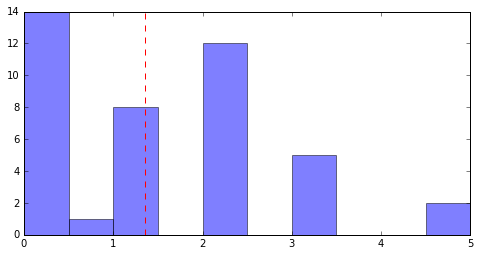

SLEEP_TIME
Unique values: 40
p-value: 0.0593165215025
Normal: True
Mean: 389.756097561 std: 72.6972785525


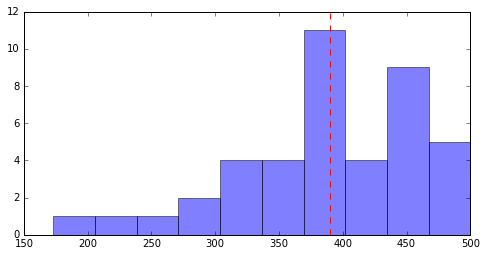

IAH
Unique values: 42
p-value: 0.190788101702
Normal: True
Mean: 53.1311904762 std: 20.7184994633


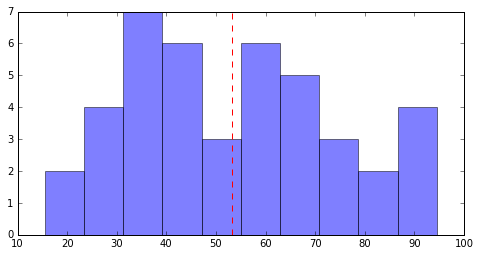

TIME_SAT<90%
Unique values: 37
p-value: 4.53235187487e-05
Normal: False
Mean: 65.3030952381 std: 74.6727674109


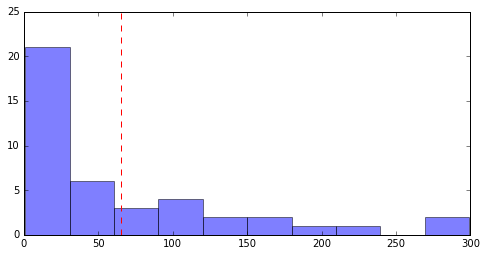

CT90%
Unique values: 29
p-value: 1.58827741694e-05
Normal: False
Mean: 19.8207142857 std: 22.7950657143


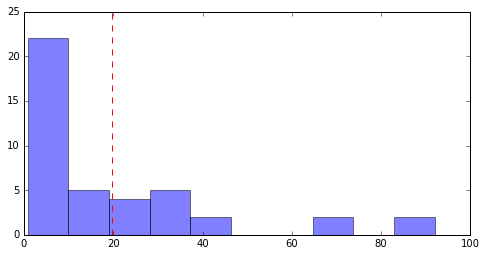

IND_DESAT
Unique values: 41
p-value: 0.0289030759687
Normal: False
Mean: 39.325 std: 25.1074142199


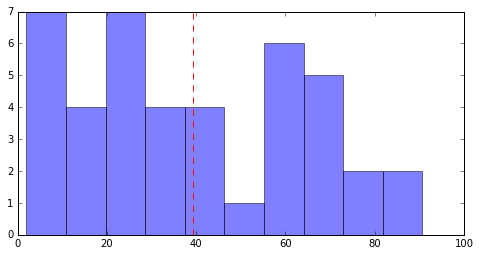

WEIGHT
Unique values: 33
p-value: 0.890508526958
Normal: True
Mean: 93.930952381 std: 16.3461294107


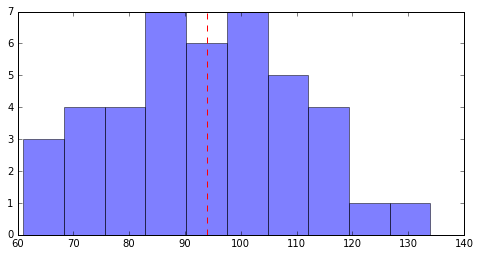

SIZE
Unique values: 24
p-value: 0.551824158919
Normal: True
Mean: 1.66833333333 std: 0.0977829634267


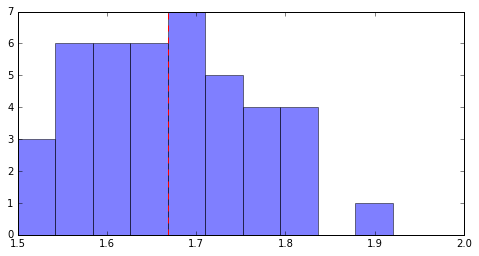

BMI
Unique values: 41
p-value: 0.210833665319
Normal: True
Mean: 33.8342857143 std: 6.38574347495


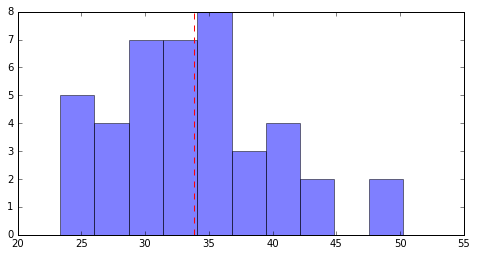

CIRC_NECK
Unique values: 15
p-value: 0.701025018709
Normal: True
Mean: 42.5238095238 std: 4.24958314616


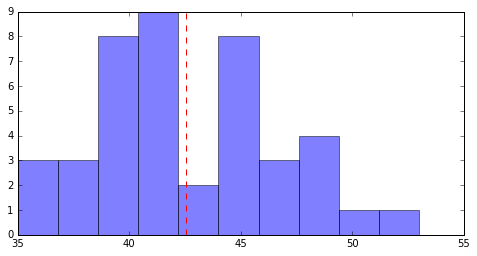

CIRC_ABD
Unique values: 34
p-value: 0.553727415261
Normal: True
Mean: 109.357142857 std: 14.3756100137


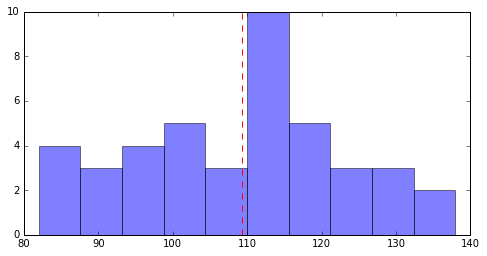

CIRC_HIP
Unique values: 27
p-value: 0.258256572652
Normal: True
Mean: 109.357142857 std: 12.8263520193


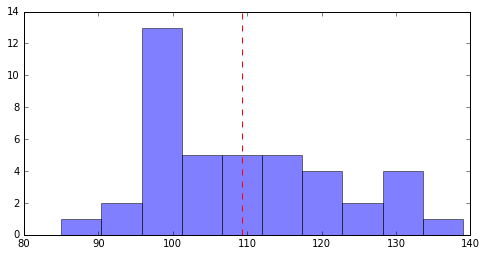

TAS_MEAN
Unique values: 38
p-value: 0.654640617192
Normal: True
Mean: 137.607142857 std: 20.3731662085


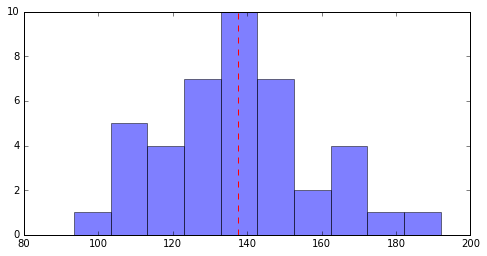

TAD_MEAN
Unique values: 32
p-value: 0.117106687769
Normal: True
Mean: 87.0 std: 14.8038765837


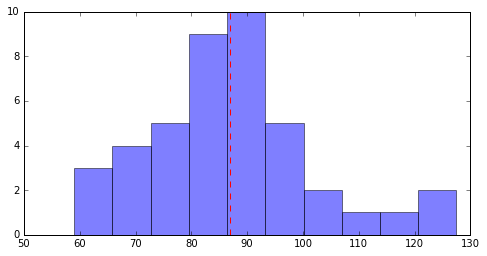

SAT_O2
Unique values: 7
p-value: 1.56957562993e-05
Normal: False
Mean: 97.4285714286 std: 1.49829835453


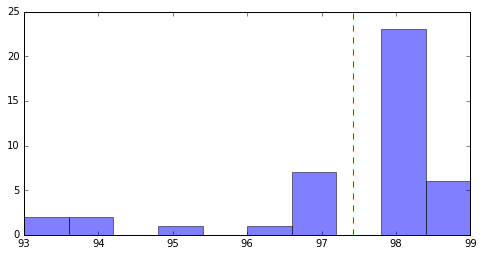

PRESS_CPAP
Unique values: 9
p-value: 0.631944751572
Normal: True
Mean: 10.9238095238 std: 1.15959958685


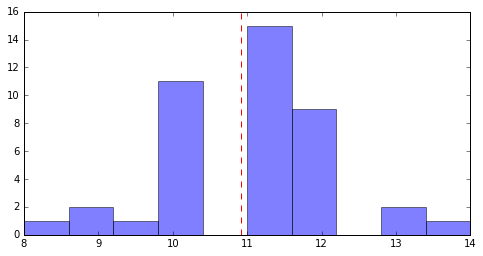

EPWORTH
Unique values: 19
p-value: 0.5007292619
Normal: True
Mean: 8.84285714286 std: 4.64789470299


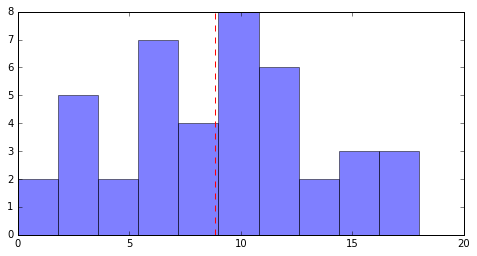

EUROQOL
Unique values: 16
p-value: 0.0434274208809
Normal: False
Mean: 0.787262142857 std: 0.217845228693


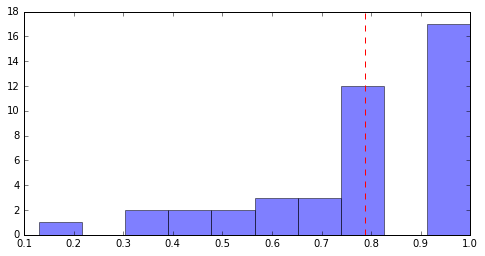

VISUAL
Unique values: 12
p-value: 0.767272513635
Normal: True
Mean: 58.119047619 std: 23.1673028836


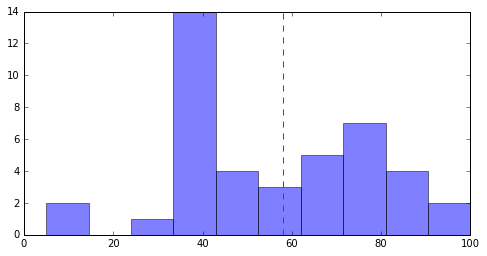

In [755]:
from scipy.stats import boxcox

for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10, alpha=0.5)
        plt.axvline(np.mean(cleanIc), c="r", ls="--")
        plt.show()        

#### Distribution categorical features

GENDER
(2,)
1.00    29
0.00    13
Name: GENDER, dtype: int64


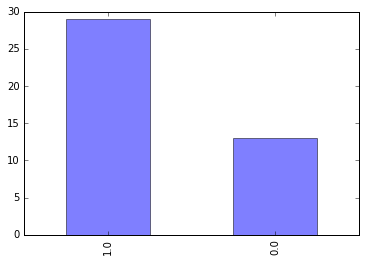

ACTIVE
(2,)
1.00    25
0.00    17
Name: ACTIVE, dtype: int64


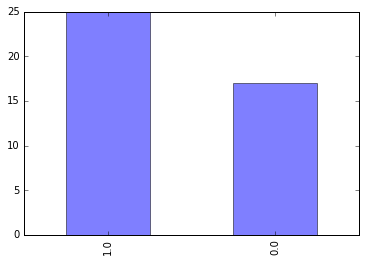

NO_ACTIVE
(2,)
0.00    25
1.00    17
Name: NO_ACTIVE, dtype: int64


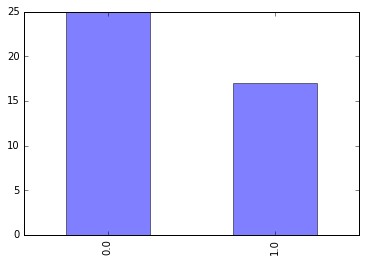

RETIRED
(2,)
0.00    28
1.00    14
Name: RETIRED, dtype: int64


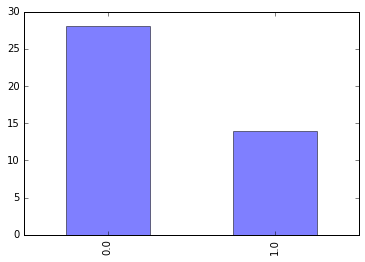

SMOKER
(2,)
0.00    26
1.00    16
Name: SMOKER, dtype: int64


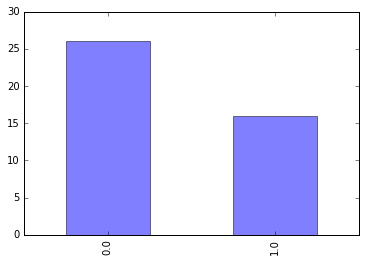

ALCOHOL
(2,)
0.00    24
1.00    18
Name: ALCOHOL, dtype: int64


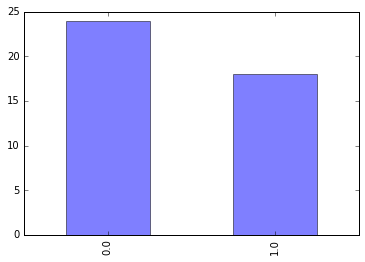

DEPRESSION
(2,)
0.00    35
1.00    7 
Name: DEPRESSION, dtype: int64


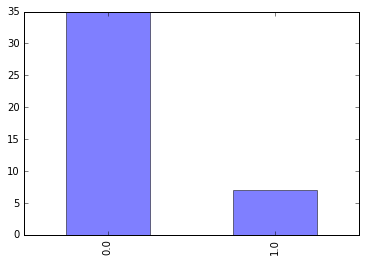

ANXIETY
(2,)
0.00    33
1.00    9 
Name: ANXIETY, dtype: int64


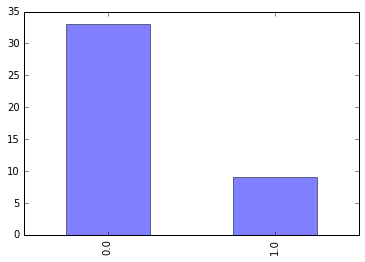

HTA
(2,)
1.00    25
0.00    17
Name: HTA, dtype: int64


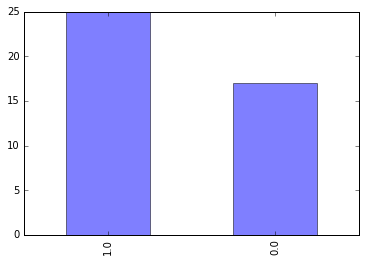

CARDIOPATHY
(2,)
0.00    30
1.00    12
Name: CARDIOPATHY, dtype: int64


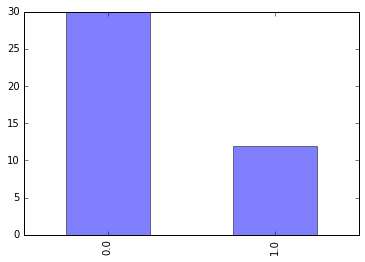

NEUR_DIS
(2,)
0.00    37
1.00    5 
Name: NEUR_DIS, dtype: int64


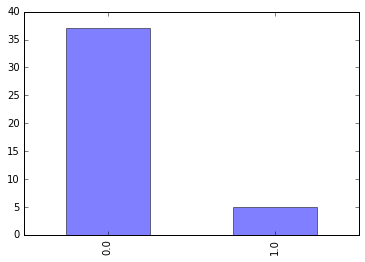

RESP_DIS
(2,)
0.00    31
1.00    11
Name: RESP_DIS, dtype: int64


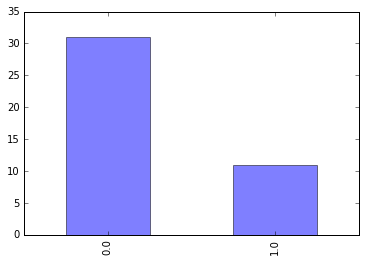

DIABETES
(2,)
0.00    29
1.00    13
Name: DIABETES, dtype: int64


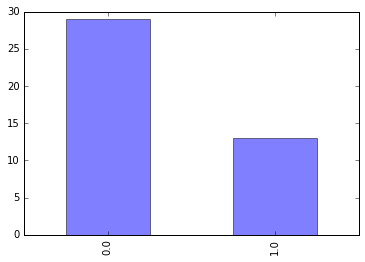

OBESITY
(2,)
1.00    30
0.00    12
Name: OBESITY, dtype: int64


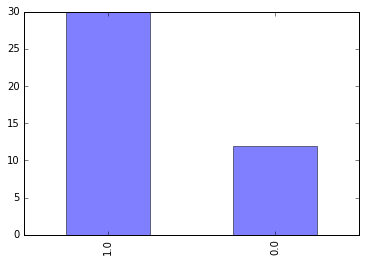

DISLIPEMIA
(2,)
0.00    26
1.00    16
Name: DISLIPEMIA, dtype: int64


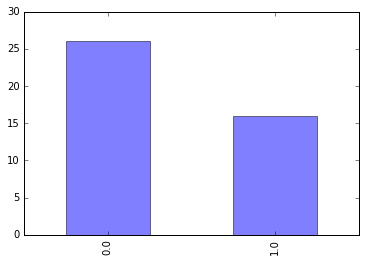

NEOPLASIA
(2,)
0.00    40
1.00    2 
Name: NEOPLASIA, dtype: int64


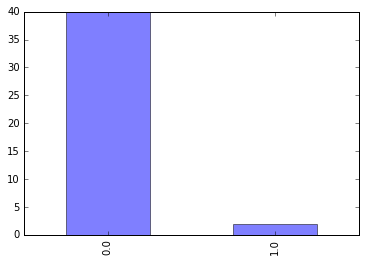

OBSTR_NASAL_CHRON
(2,)
0.00    27
1.00    15
Name: OBSTR_NASAL_CHRON, dtype: int64


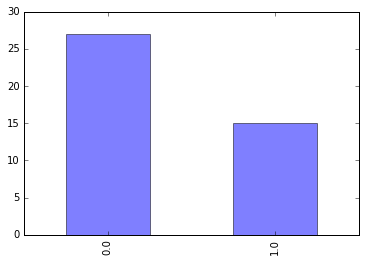

ORAL_SUR
(2,)
0.00    37
1.00    5 
Name: ORAL_SUR, dtype: int64


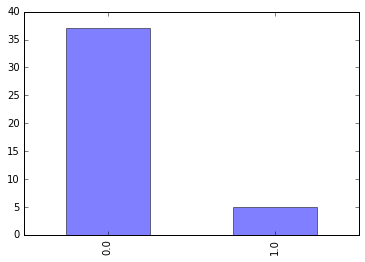

SNORES
(3,)
3.00    29
2.00    10
1.00    3 
Name: SNORES, dtype: int64


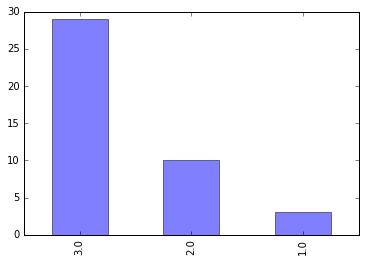

REP_SLEEP
(4,)
2.00    19
0.00    11
1.00    7 
3.00    5 
Name: REP_SLEEP, dtype: int64


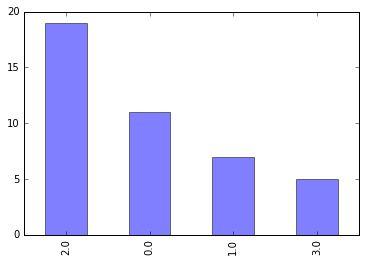

CRISIS_ASP
(3,)
0.00    24
1.00    14
2.00    4 
Name: CRISIS_ASP, dtype: int64


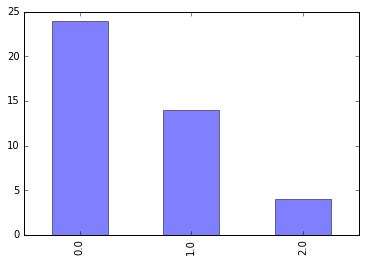

NOCTURIA
(4,)
3.00    16
1.00    12
0.00    9 
2.00    5 
Name: NOCTURIA, dtype: int64


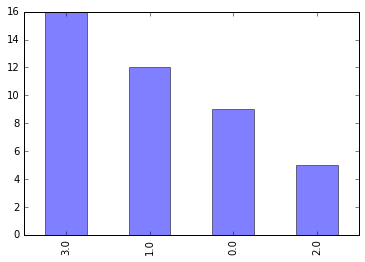

APNEAS_PRES
(4,)
2.00    13
0.00    10
1.00    10
3.00    9 
Name: APNEAS_PRES, dtype: int64


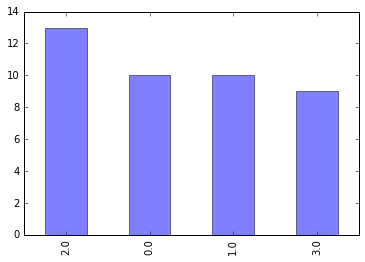

CEFALEA
(4,)
0.00    29
1.00    11
2.00    1 
3.00    1 
Name: CEFALEA, dtype: int64


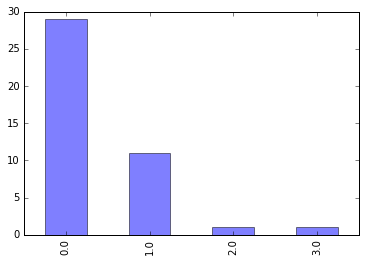

DAY_SOMN
(4,)
0.00    13
1.00    11
2.00    10
3.00    8 
Name: DAY_SOMN, dtype: int64


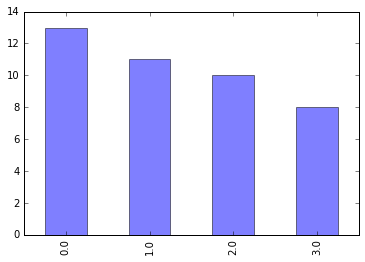

AWAKE_NIGHT
(4,)
0.00    21
2.00    11
3.00    5 
1.00    5 
Name: AWAKE_NIGHT, dtype: int64


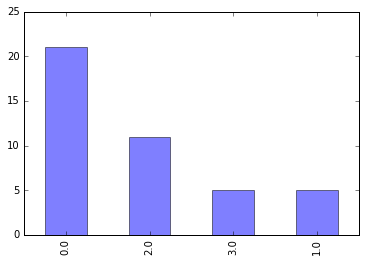

MEM_DIS
(3,)
0.00    27
1.00    9 
2.00    6 
Name: MEM_DIS, dtype: int64


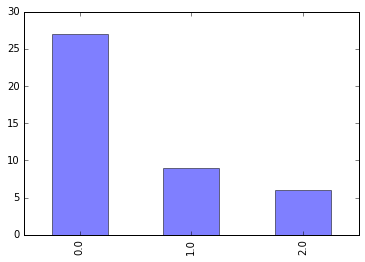

CONC_DIS
(3,)
0.00    29
1.00    7 
2.00    6 
Name: CONC_DIS, dtype: int64


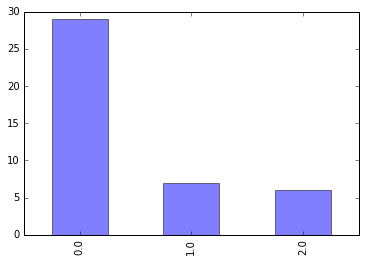

IRR_APAT_DEPRE
(3,)
0.00    23
1.00    13
2.00    6 
Name: IRR_APAT_DEPRE, dtype: int64


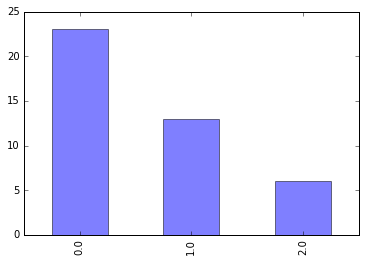

INSOMNIA
(2,)
0.00    35
1.00    7 
Name: INSOMNIA, dtype: int64


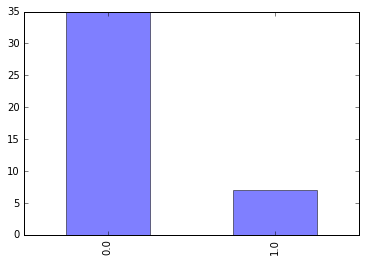

ACT_MOTR_NOCT
(2,)
0.00    27
1.00    15
Name: ACT_MOTR_NOCT, dtype: int64


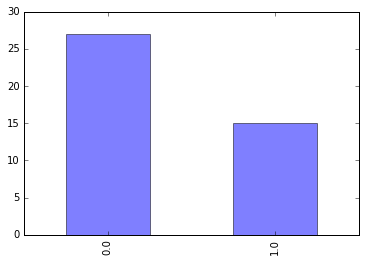

LEG_PAIN_MOVE
(2,)
0.00    38
1.00    4 
Name: LEG_PAIN_MOVE, dtype: int64


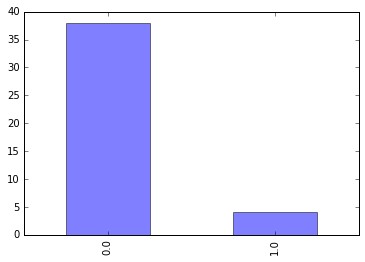

INV_MOV_SLEEP
(2,)
0.00    39
1.00    3 
Name: INV_MOV_SLEEP, dtype: int64


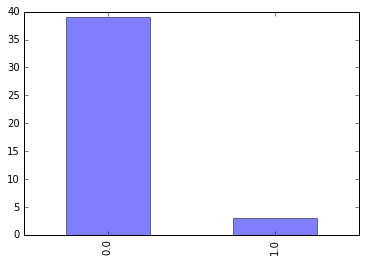

FEEL_REAL_DRE
(2,)
0.00    33
1.00    9 
Name: FEEL_REAL_DRE, dtype: int64


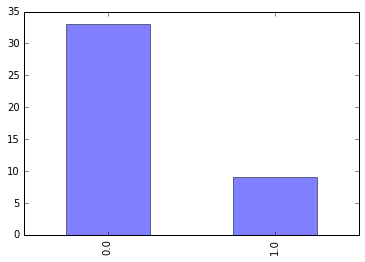

DREAM_INT_PIROSIS
(2,)
0.00    33
1.00    9 
Name: DREAM_INT_PIROSIS, dtype: int64


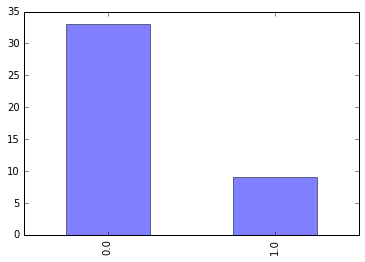

FLEE_TEETH_SLEEP
(2,)
0.00    38
1.00    4 
Name: FLEE_TEETH_SLEEP, dtype: int64


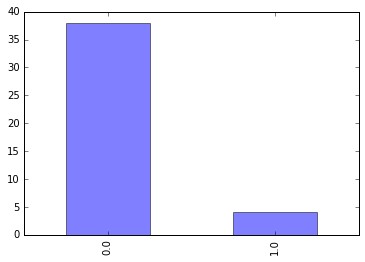

DEC_SEX_DIS
(2,)
0.00    25
1.00    17
Name: DEC_SEX_DIS, dtype: int64


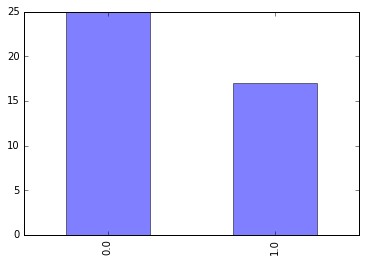

IECAS
(2,)
0.00    29
1.00    13
Name: IECAS, dtype: int64


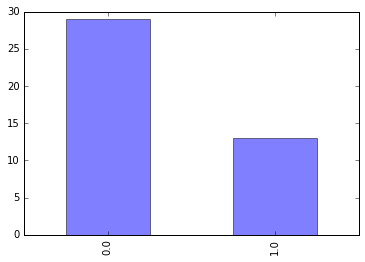

BBLOQ
(2,)
0.00    38
1.00    4 
Name: BBLOQ, dtype: int64


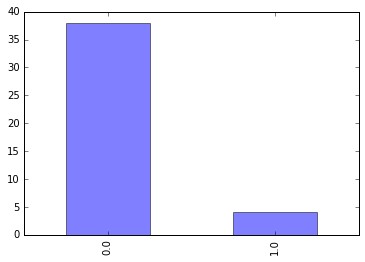

DIURETICS
(2,)
0.00    32
1.00    10
Name: DIURETICS, dtype: int64


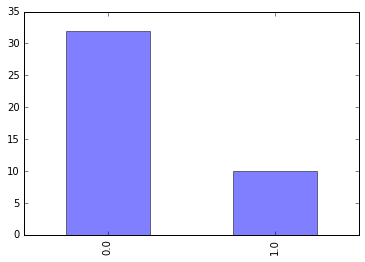

CA-ANTAG
(2,)
0.00    37
1.00    5 
Name: CA-ANTAG, dtype: int64


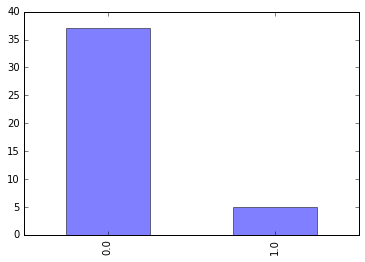

ARA-II
(2,)
0.00    37
1.00    5 
Name: ARA-II, dtype: int64


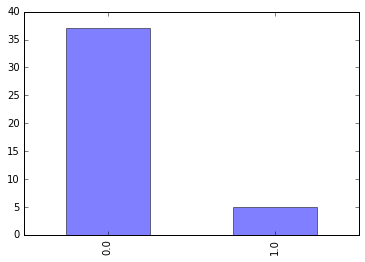

ANTIAGREG
(2,)
0.00    33
1.00    9 
Name: ANTIAGREG, dtype: int64


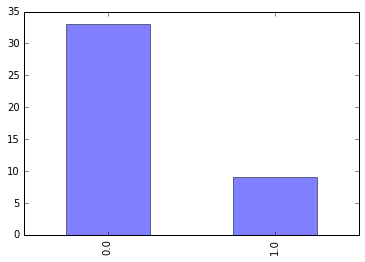

ANTICOAG
(2,)
0.00    37
1.00    5 
Name: ANTICOAG, dtype: int64


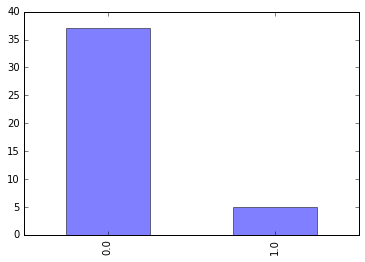

ANTIACID
(2,)
0.00    32
1.00    10
Name: ANTIACID, dtype: int64


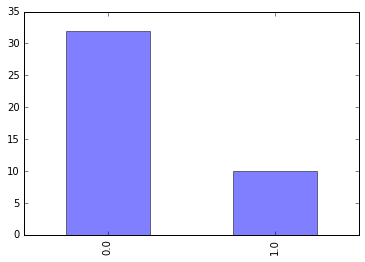

BRONCODIL
(2,)
0.00    37
1.00    5 
Name: BRONCODIL, dtype: int64


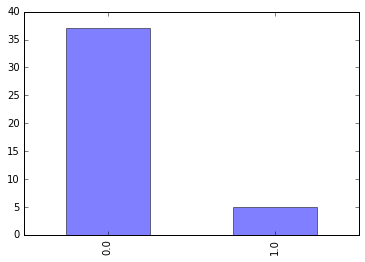

ADO
(2,)
0.00    33
1.00    9 
Name: ADO, dtype: int64


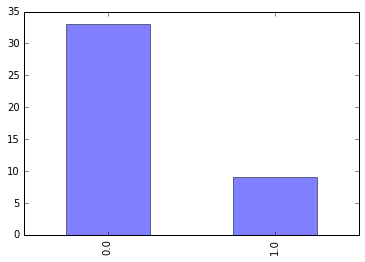

INSULIN
(2,)
0.00    38
1.00    4 
Name: INSULIN, dtype: int64


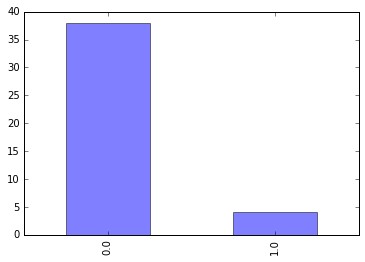

HIPOLIPEM
(2,)
0.00    27
1.00    15
Name: HIPOLIPEM, dtype: int64


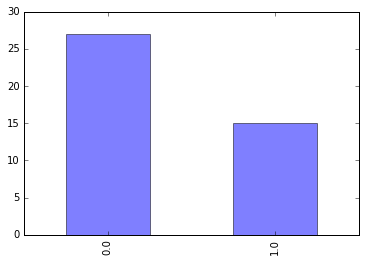

BDZ
(2,)
0.00    35
1.00    7 
Name: BDZ, dtype: int64


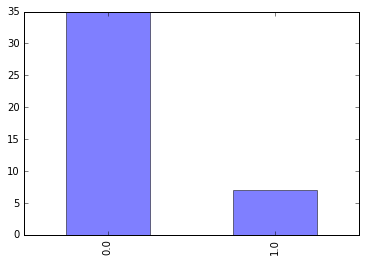

ANTIDEPRE
(2,)
0.00    35
1.00    7 
Name: ANTIDEPRE, dtype: int64


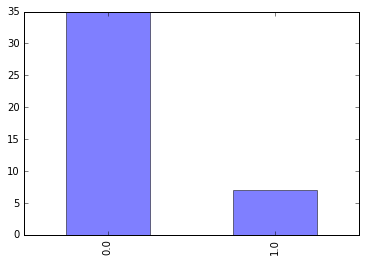

OTHER_PSICO
(2,)
0.00    37
1.00    5 
Name: OTHER_PSICO, dtype: int64


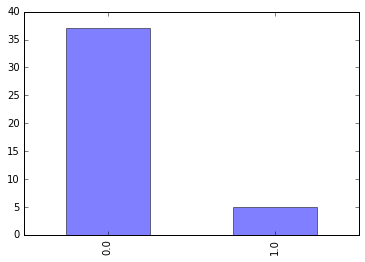

OTHER_HIPOT
(2,)
0.00    40
1.00    2 
Name: OTHER_HIPOT, dtype: int64


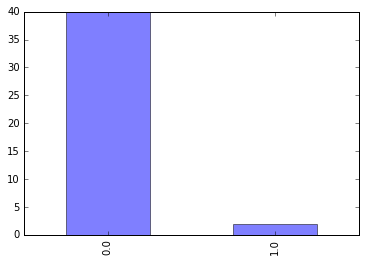

In [756]:
for i,rv in enumerate(columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":
                
        print rv
        print pd.value_counts(cleanIc).shape
        print pd.value_counts(cleanIc)
        pd.value_counts(cleanIc).plot(kind="bar", alpha=0.5)
        plt.show()        

In [757]:
# Individuals of categories less representative to another 
# more representative without loosing meaning

df_all[dfFeatures.ix["RONCA"].Name][dfFeatures.ix["RONCA"].Name] = 2.0
df_all[dfFeatures.ix["RONCA"].Name][df_all[dfFeatures.ix["RONCA"].Name]==2.0] = 0.0
df_all[dfFeatures.ix["RONCA"].Name][df_all[dfFeatures.ix["RONCA"].Name]==3.0] = 1.0

df_all[dfFeatures.ix["CEFALEA"].Name][df_all[dfFeatures.ix["CEFALEA"].Name]>1.0] = 1.0

dfImputed[dfFeatures.ix["RONCA"].Name][dfImputed[dfFeatures.ix["RONCA"].Name]==1.0] = 2.0
dfImputed[dfFeatures.ix["RONCA"].Name][dfImputed[dfFeatures.ix["RONCA"].Name]==2.0] = 0.0
dfImputed[dfFeatures.ix["RONCA"].Name][dfImputed[dfFeatures.ix["RONCA"].Name]==3.0] = 1.0
dfImputed[dfFeatures.ix["CEFALEA"].Name][dfImputed[dfFeatures.ix["CEFALEA"].Name]>1.0] = 1.0

print df_all[dfFeatures.ix["RONCA"].Name].unique()
print dfImputed[dfFeatures.ix["RONCA"].Name].unique()
print df_all[dfFeatures.ix["CEFALEA"].Name].unique()
print dfImputed[dfFeatures.ix["CEFALEA"].Name].unique()

[ 1.  0.]
[ 1.  0.]
[0 1]
[ 0.  1.]


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Features with underrespresented categories
(Few instances in a category)

In [758]:
minConts = []
for i,rv in enumerate(columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":                
        minConts.append([rv,
                         pd.value_counts(cleanIc).index.tolist(), 
                         pd.value_counts(cleanIc).values.tolist(),
                         (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                         pd.value_counts(cleanIc).values.min(),
                         pd.value_counts(cleanIc).values.max()
                        ])    
dfCatSum = pd.DataFrame(minConts, columns=["variable","categories","frequencies","ratios","min","max"])

In [759]:
to_del = dfFeatures.ix[["ENF_NEUR","NEOPLASIA","CIRUGIA_ORL","DOLOR_PIER_MOVER", "MOV_BRUSC_INV_DUERME",
"FROTA_DIENT_DUERM","BBLOQ","CA-ANTAG",  "ARA-II","ANTICOAG", "BRONCODIL", "INSULINA",
"OTROS_PSICO", "OTROS_HIPOT"]].Name.tolist()

display(HTML(dfCatSum[dfCatSum["variable"].isin(to_del)].to_html(index=False)))
print dfCatSum[dfCatSum["variable"].isin(to_del)].shape
print len(to_del)

variable,categories,frequencies,ratios,min,max
NEUR_DIS,"[0.0, 1.0]","[37, 5]","[0.88, 0.12]",5,37
NEOPLASIA,"[0.0, 1.0]","[40, 2]","[0.95, 0.05]",2,40
ORAL_SUR,"[0.0, 1.0]","[37, 5]","[0.88, 0.12]",5,37
LEG_PAIN_MOVE,"[0.0, 1.0]","[38, 4]","[0.9, 0.1]",4,38
INV_MOV_SLEEP,"[0.0, 1.0]","[39, 3]","[0.93, 0.07]",3,39
FLEE_TEETH_SLEEP,"[0.0, 1.0]","[38, 4]","[0.9, 0.1]",4,38
BBLOQ,"[0.0, 1.0]","[38, 4]","[0.9, 0.1]",4,38
CA-ANTAG,"[0.0, 1.0]","[37, 5]","[0.88, 0.12]",5,37
ARA-II,"[0.0, 1.0]","[37, 5]","[0.88, 0.12]",5,37
ANTICOAG,"[0.0, 1.0]","[37, 5]","[0.88, 0.12]",5,37


(14, 6)
14


#### Correlated numerical features

In [760]:
dfImputedLabel = pd.concat([dfImputed,df_all.iloc[:,-1]], axis=1)
print dfImputedLabel.shape

(42, 77)


In [761]:
#Correlations

relVars = df_all.columns[:-1][catCols==0]
relVars = [c for c in relVars.values if c not in to_del]

dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values
        
        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")
        
        #Pearson corr, classical
        cv1_norm = np.log(cv1 + 1)#preprocessing.normalize(cv1.reshape(-1, 1))
        cv2_norm = np.log(cv2 + 1)#preprocessing.normalize(cv2.reshape(-1, 1))
        c_pr,p_pr = stats.pearsonr(cv1_norm,cv2_norm)
        
        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        
        sc1, pval1 = stats.mannwhitneyu(cv1.reshape(-1,1),df_all.iloc[:,-1].values.reshape(-1,1))
        sc2, pval2 = stats.mannwhitneyu(cv2.reshape(-1,1),df_all.iloc[:,-1].reshape(-1,1))
                
        
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi, pval1, pval2])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi","pval_cv1","pval_cv2"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
dfCorr["pval_cv1"] = dfCorr["pval_cv1"].astype(float)
dfCorr["pval_cv2"] = dfCorr["pval_cv2"].astype(float)

print dfCorr.shape

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(529, 10)


In [762]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_sp"] >= 0.8, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_sp"]].to_html(index=False)))

cov1,cov2,c_sp
TIME_SAT<90%,CT90%,0.929
CT90%,TIME_SAT<90%,0.929
WEIGHT,BMI,0.805
WEIGHT,CIRC_HIP,0.803
BMI,WEIGHT,0.805
BMI,CIRC_ABD,0.868
BMI,CIRC_HIP,0.830
CIRC_ABD,BMI,0.868
CIRC_HIP,WEIGHT,0.803
CIRC_HIP,BMI,0.830


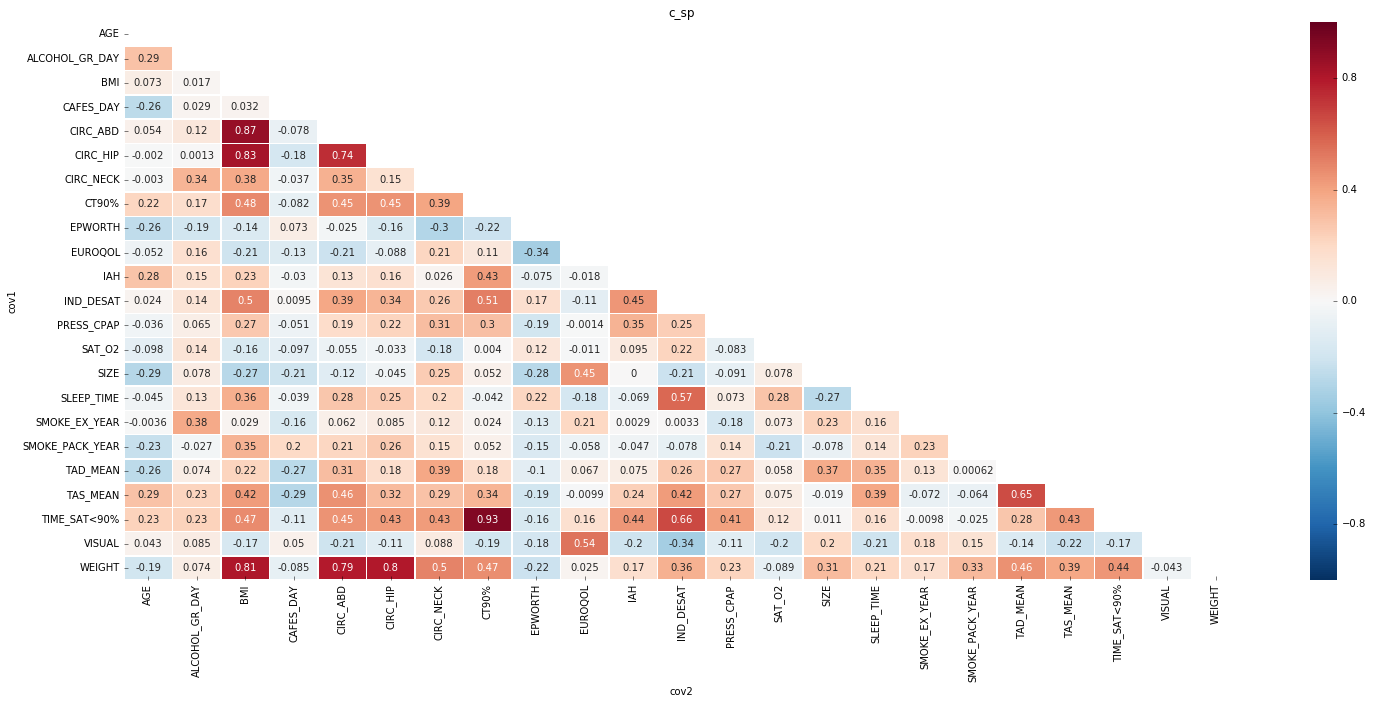

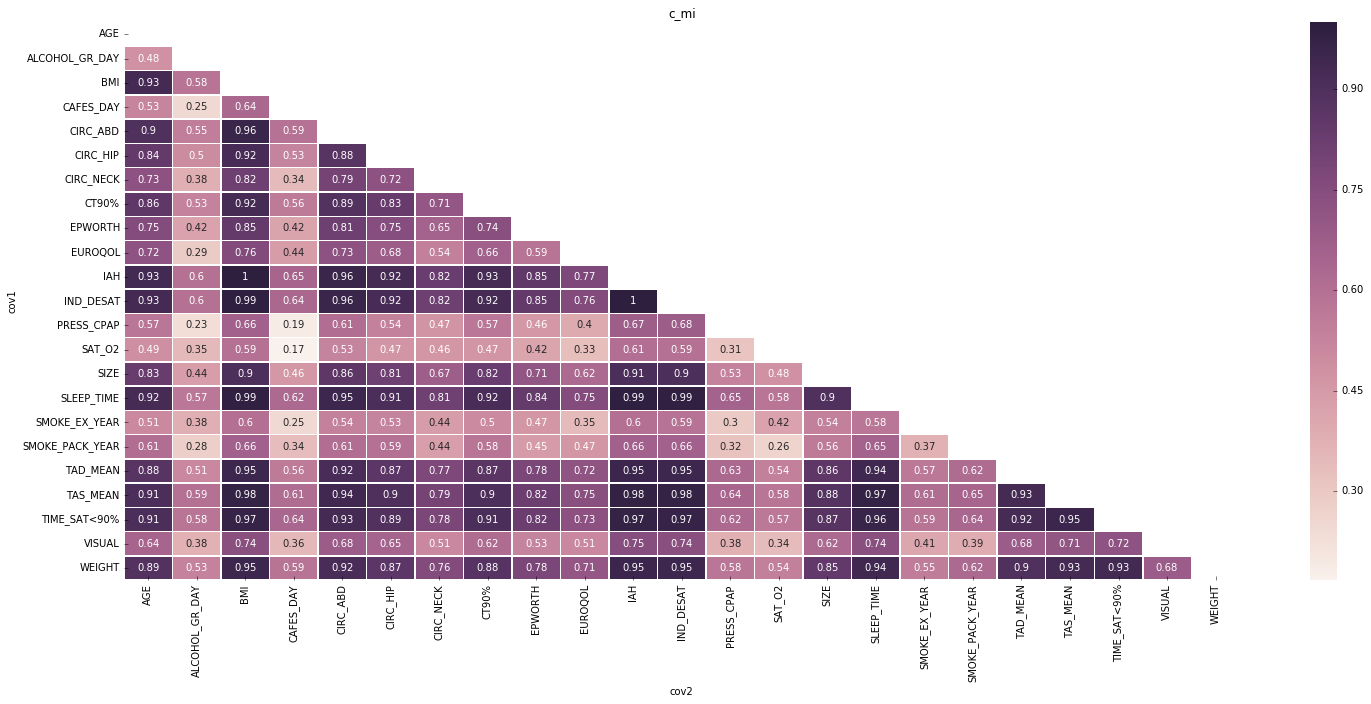

In [763]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,10))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".2g")
    
    plt.title(c)

#### Numerical features to remove

In [764]:
to_del.extend(dfFeatures.ix[["CIRC_ABD","CIRC_CADERA","PESO","CT90%"]].Name)
print len(to_del), to_del

18 ['NEUR_DIS', 'NEOPLASIA', 'ORAL_SUR', 'LEG_PAIN_MOVE', 'INV_MOV_SLEEP', 'FLEE_TEETH_SLEEP', 'BBLOQ', 'CA-ANTAG', 'ARA-II', 'ANTICOAG', 'BRONCODIL', 'INSULIN', 'OTHER_PSICO', 'OTHER_HIPOT', 'CIRC_ABD', 'CIRC_HIP', 'WEIGHT', 'CT90%']


#### Correlations on categorical features

In [765]:
#Correlations

relVars = df_all.columns[:-1][catCols==1]
relVars = [c for c in relVars.values if c not in to_del]
dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values

        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")

        #Pearson corr, classical
        c_pr,p_pr = stats.pearsonr(cv1,cv2)

        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
print dfCorr.shape

(1521, 8)


In [766]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_mi"] >= 0.5, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_mi"]].to_html(index=False)))

cov1,cov2,c_mi
ACTIVE,NO_ACTIVE,1.000
ACTIVE,RETIRED,0.683
NO_ACTIVE,ACTIVE,1.000
NO_ACTIVE,RETIRED,0.683
RETIRED,ACTIVE,0.683
RETIRED,NO_ACTIVE,0.683
DEPRESSION,ANTIDEPRE,0.608
DIABETES,ADO,0.579
MEM_DIS,CONC_DIS,0.540
CONC_DIS,MEM_DIS,0.540


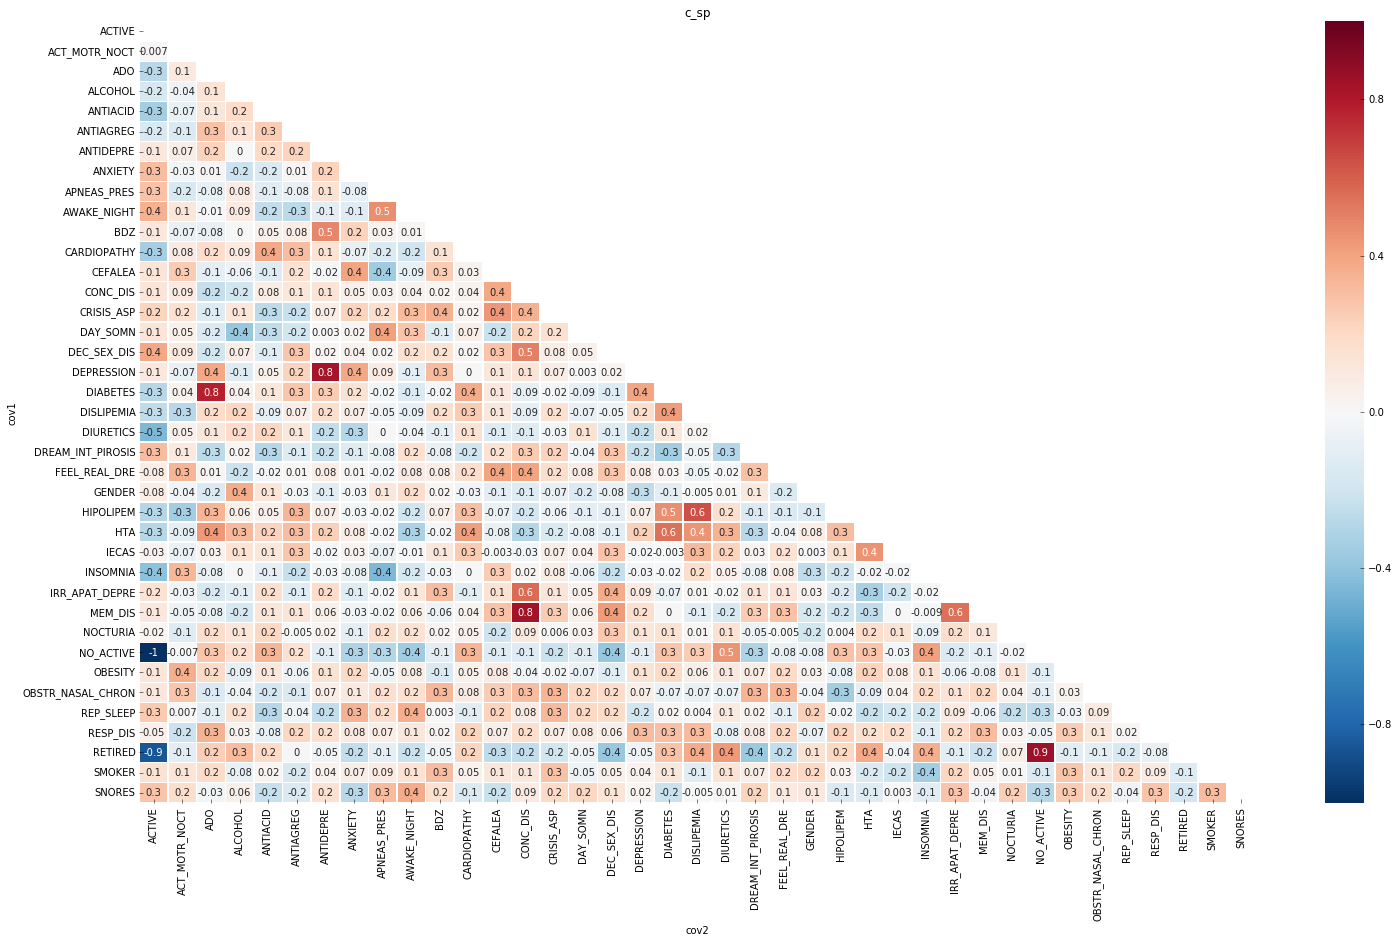

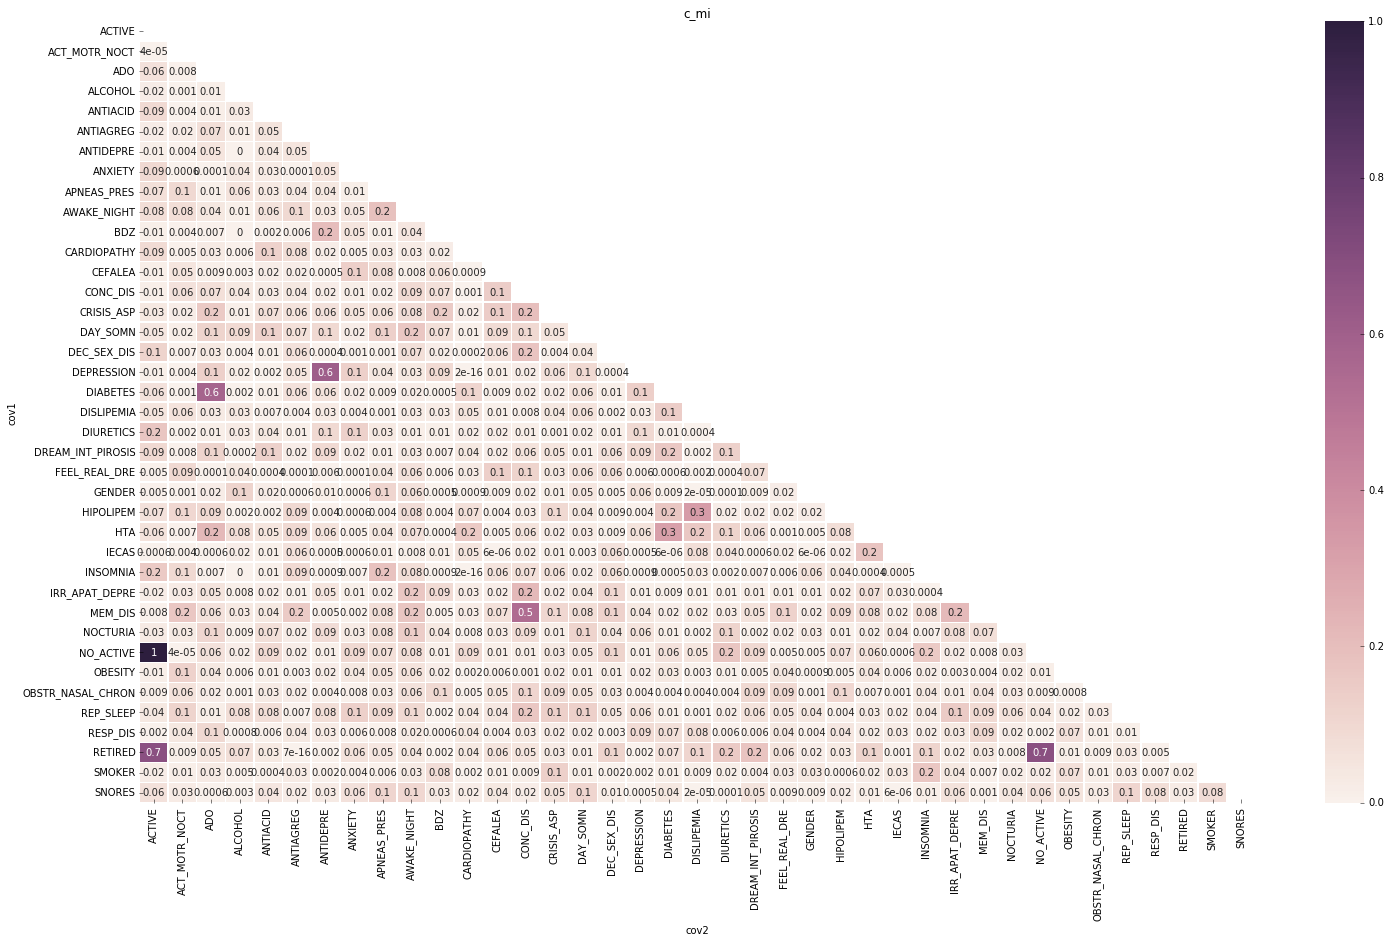

In [767]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,14))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".1g")
    
    plt.title(c)

#### Categorical features to remove

In [768]:
to_del.extend(dfFeatures.ix[["NO_ACTIVO","ANTIDEPRE","ADO","TRAST_MEM"]].Name)
print len(to_del), to_del

22 ['NEUR_DIS', 'NEOPLASIA', 'ORAL_SUR', 'LEG_PAIN_MOVE', 'INV_MOV_SLEEP', 'FLEE_TEETH_SLEEP', 'BBLOQ', 'CA-ANTAG', 'ARA-II', 'ANTICOAG', 'BRONCODIL', 'INSULIN', 'OTHER_PSICO', 'OTHER_HIPOT', 'CIRC_ABD', 'CIRC_HIP', 'WEIGHT', 'CT90%', 'NO_ACTIVE', 'ANTIDEPRE', 'ADO', 'MEM_DIS']


### 2. Inspect feature vs class

In [769]:
thrs = [3.5, 3.9, 4.0, 4.2, 4.5, 5.0]
thr = thrs[-4]
print "Selected threshold:",  thr

Selected threshold: 4.0


In [770]:
#dfImputed = pd.DataFrame(dfImputed, columns=reducedCols)
print "THR:", thr
df_all["LABEL"] = pd.to_numeric(df_all["LABEL"])
dfImputed["LABEL"] = df_all["LABEL"]
dfImputed["LABEL"] = dfImputed["LABEL"].astype(float)

dfImputed["LABEL"][np.where(dfImputed["LABEL"] <= float(thr))[0]] = 0
dfImputed["LABEL"][np.where(dfImputed["LABEL"] > float(thr))[0]] = 1
dfImputed["LABEL"] = dfImputed["LABEL"].astype(int)

print pd.value_counts(dfImputed["LABEL"])

THR: 4.0
1    27
0    15
Name: LABEL, dtype: int64


[0.0, 0.0, 0.97, 2.08, 2.12, 2.6, 3.32, 3.5, 3.5, 3.8, 3.93, 4.0, 4.0, 4.0, 4.0, 4.5, 4.5, 4.99, 5.0, 5.0, 5.32, 5.5, 5.5, 5.5, 6.0, 6.0, 6.5, 6.5, 6.5, 6.5, 6.51, 7.0, 7.0, 7.0, 7.0, 7.0, 7.5, 7.5, 7.5, 7.5, 8.0, 8.0]


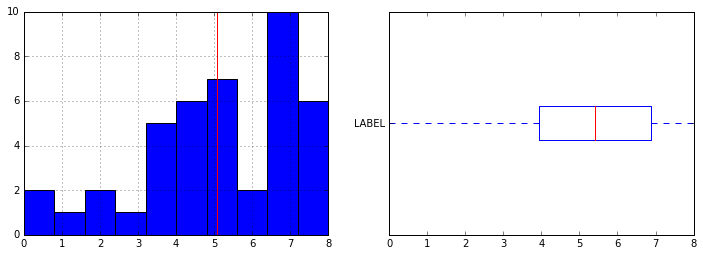

count   42.000
mean    5.075 
std     2.096 
min     0.000 
25%     3.948 
50%     5.410 
75%     6.877 
max     8.000 
Name: LABEL, dtype: float64

In [771]:
# Compute label column
lblCol = df_all["LABEL"]
lblCol = pd.to_numeric(lblCol)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
print lblCol.sort_values().tolist()
lblCol.hist(ax = ax)
ax.axvline(lblCol.mean(), c="r")
ax = plt.subplot(1,2,2)
lblCol.plot(kind="box", ax=ax, rot=0, vert=False)
plt.show()
lblCol.describe()

#### Categorical features vs label (proportions)

In [772]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

In [773]:
sigArr = []

GENDER
   LABEL  GENDER  count  perc
0  0     0.000    5     0.333
1  0     1.000    10    0.667
2  1     0.000    8     0.296
3  1     1.000    19    0.704
0.00990274093722 0.92073135051 ['no']
[ 0.01915709] [ 0.88991708] ['no']


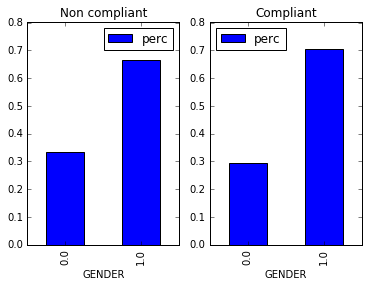

ACTIVE
   LABEL  ACTIVE  count  perc
0  0     0.000    7     0.467
1  0     1.000    8     0.533
2  1     0.000    10    0.370
3  1     1.000    17    0.630
0.0790588235294 0.77857693838 ['no']
[ 0.15022222] [ 0.69832309] ['no']


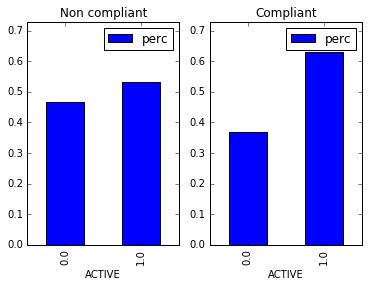

NO_ACTIVE
   LABEL  NO_ACTIVE  count  perc
0  0     0.000       8     0.533
1  0     1.000       7     0.467
2  1     0.000       17    0.630
3  1     1.000       10    0.370
0.0790588235294 0.77857693838 ['no']
[ 0.22091503] [ 0.63834359] ['no']


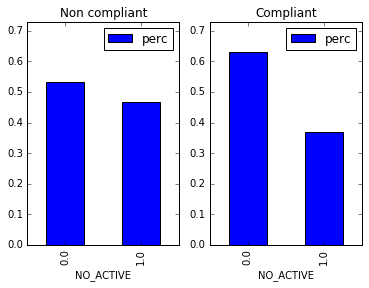

RETIRED
   LABEL  RETIRED  count  perc
0  0     0.000     9     0.600
1  0     1.000     6     0.400
2  1     0.000     19    0.704
3  1     1.000     8     0.296
0.116666666667 0.732678261376 ['no']
[ 0.31111111] [ 0.57699916] ['no']


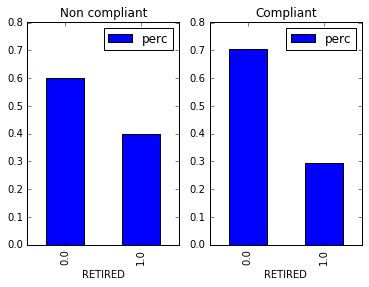

SMOKER
   LABEL  SMOKER  count  perc
0  0     0.000    9     0.600
1  0     1.000    6     0.400
2  1     0.000    17    0.630
3  1     1.000    10    0.370
0.0201923076923 0.887001302518 ['no']
[ 0.02222222] [ 0.88149745] ['no']


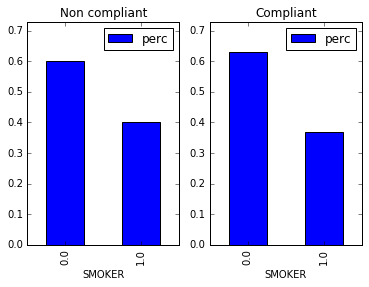

ALCOHOL
   LABEL  ALCOHOL  count  perc
0  0     0.000     10    0.667
1  0     1.000     5     0.333
2  1     0.000     14    0.519
3  1     1.000     13    0.481
0.36512345679 0.545674475979 ['no']
[ 0.49382716] [ 0.48222504] ['no']


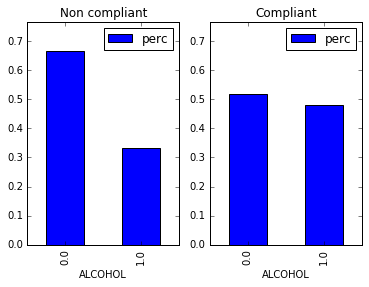

DEPRESSION
   LABEL  DEPRESSION  count  perc
0  0     0.000        14    0.933
1  0     1.000        1     0.067
2  1     0.000        21    0.778
3  1     1.000        6     0.222
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


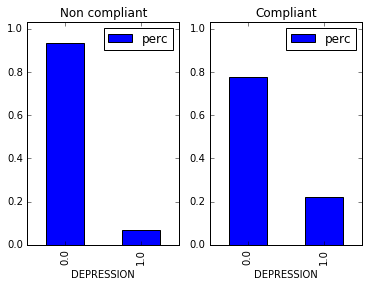

ANXIETY
   LABEL  ANXIETY  count  perc
0  0     0.000     11    0.733
1  0     1.000     4     0.267
2  1     0.000     22    0.815
3  1     1.000     5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


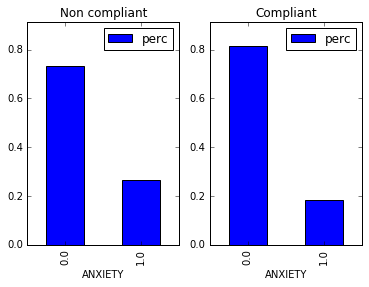

HTA
   LABEL   HTA  count  perc
0  0     0.000  10    0.667
1  0     1.000  5     0.333
2  1     0.000  7     0.259
3  1     1.000  20    0.741
5.05976470588 0.024487562385 ['yes']
[ 2.68888889] [ 0.10105026] ['no']


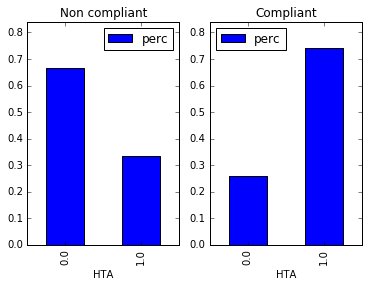

CARDIOPATHY
   LABEL  CARDIOPATHY  count  perc
0  0     0.000         12    0.800
1  0     1.000         3     0.200
2  1     0.000         18    0.667
3  1     1.000         9     0.333
0.313703703704 0.575416287928 ['no']
[ 0.6] [ 0.43857803] ['no']


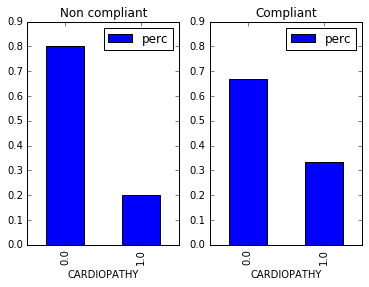

NEUR_DIS
   LABEL  NEUR_DIS  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      25    0.926
3  1     1.000      2     0.074
0.504504504505 0.477527540472 ['no']
[ 1.28444444] [ 0.2570743] ['no']


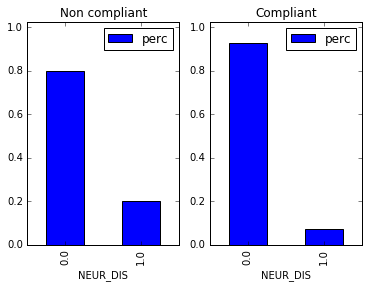

RESP_DIS
   LABEL  RESP_DIS  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      19    0.704
3  1     1.000      8     0.296
0.0985337243402 0.753596368123 ['no']
[ 0.34141414] [ 0.55901409] ['no']


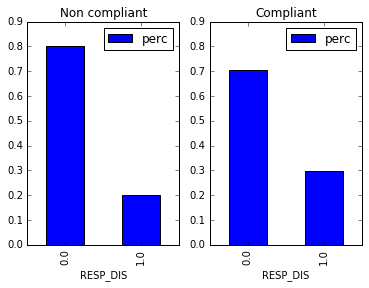

DIABETES
   LABEL  DIABETES  count  perc
0  0     0.000      11    0.733
1  0     1.000      4     0.267
2  1     0.000      18    0.667
3  1     1.000      9     0.333
0.00990274093722 0.92073135051 ['no']
[ 0.13846154] [ 0.70981527] ['no']


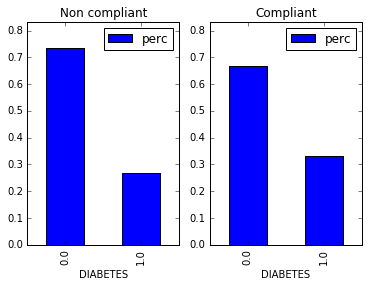

OBESITY
   LABEL  OBESITY  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     6     0.222
3  1     1.000     21    0.778
0.749259259259 0.386710855045 ['no']
[ 0.42666667] [ 0.51362911] ['no']


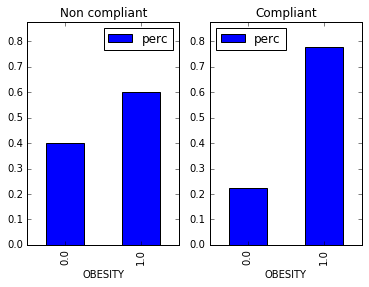

DISLIPEMIA
   LABEL  DISLIPEMIA  count  perc
0  0     0.000        8     0.533
1  0     1.000        7     0.467
2  1     0.000        18    0.667
3  1     1.000        9     0.333
0.271474358974 0.602344470315 ['no']
[ 0.45] [ 0.50233495] ['no']


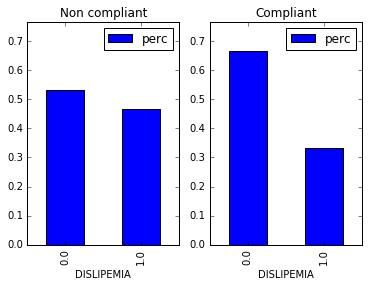

NEOPLASIA
   LABEL  NEOPLASIA  count  perc
0  0     0.000       15    1.000
1  1     0.000       25    0.926
2  1     1.000       2     0.074
0.105 0.745909995805 ['no']
[ 1.11111111] [ 0.29184055] ['no']


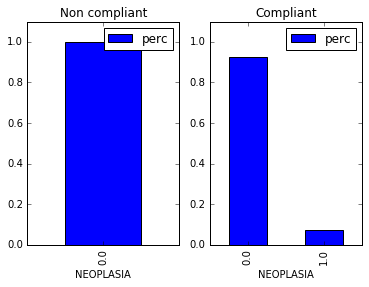

OBSTR_NASAL_CHRON
   LABEL  OBSTR_NASAL_CHRON  count  perc
0  0     0.000               8     0.533
1  0     1.000               7     0.467
2  1     0.000               19    0.704
3  1     1.000               8     0.296
0.589958847737 0.442435032483 ['no']
[ 0.7837037] [ 0.3760108] ['no']


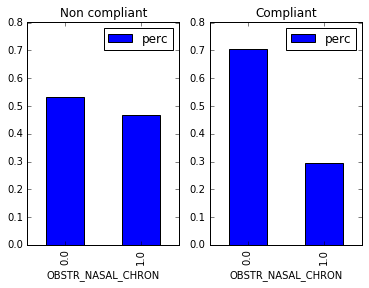

ORAL_SUR
   LABEL  ORAL_SUR  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      25    0.926
3  1     1.000      2     0.074
0.504504504505 0.477527540472 ['no']
[ 1.28444444] [ 0.2570743] ['no']


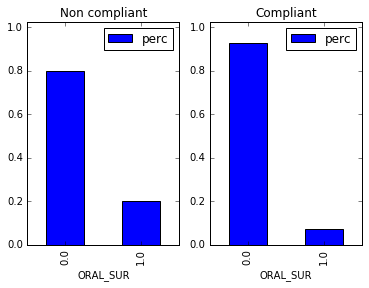

SNORES
   LABEL  SNORES  count  perc
0  0     0.000    6     0.400
1  0     1.000    9     0.600
2  1     0.000    7     0.259
3  1     1.000    20    0.741
0.35649867374 0.550457242177 ['no']
[ 0.27662835] [ 0.59891968] ['no']


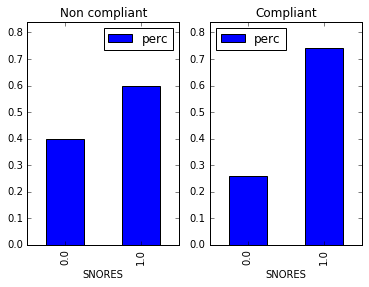

REP_SLEEP
   LABEL  REP_SLEEP  count  perc
0  0     0.000       3     0.200
1  0     1.000       2     0.133
2  0     2.000       8     0.533
3  0     3.000       2     0.133
4  1     0.000       8     0.296
5  1     1.000       5     0.185
6  1     2.000       11    0.407
7  1     3.000       3     0.111
0.874981392876 0.831460787804 ['no']
[ 0.48] [ 0.48842232] ['no']


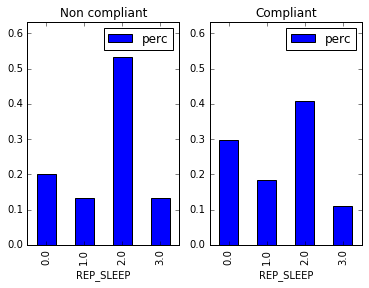

CRISIS_ASP
   LABEL  CRISIS_ASP  count  perc
0  0     0.000        6     0.400
1  0     1.000        7     0.467
2  0     2.000        2     0.133
3  1     0.000        18    0.667
4  1     1.000        7     0.259
5  1     2.000        2     0.074
2.8 0.246596963942 ['no']
[ 1.95555556] [ 0.16198944] ['no']


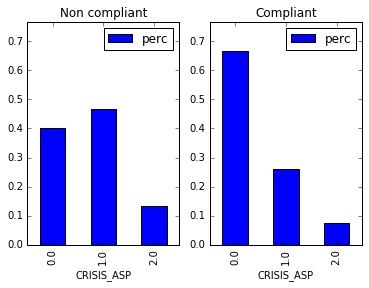

NOCTURIA
   LABEL  NOCTURIA  count  perc
0  0     0.000      4     0.267
1  0     1.000      5     0.333
2  0     2.000      1     0.067
3  0     3.000      5     0.333
4  1     0.000      5     0.185
5  1     1.000      7     0.259
6  1     2.000      4     0.148
7  1     3.000      11    0.407
1.16061728395 0.762464566771 ['no']
[ 0.56] [ 0.45426024] ['no']


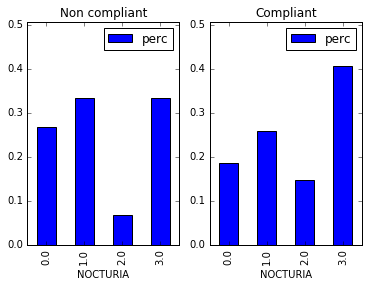

APNEAS_PRES
   LABEL  APNEAS_PRES  count  perc
0  0     0.000         4     0.267
1  0     1.000         5     0.333
2  0     2.000         4     0.267
3  0     3.000         2     0.133
4  1     0.000         6     0.222
5  1     1.000         5     0.185
6  1     2.000         9     0.333
7  1     3.000         7     0.259
1.82093067426 0.610390813319 ['no']
[ 0.84691358] [ 0.35742694] ['no']


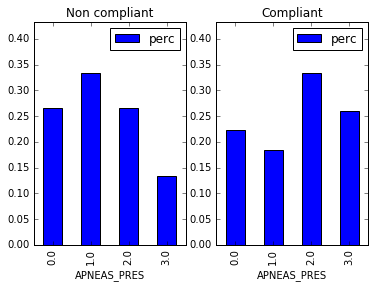

CEFALEA
   LABEL  CEFALEA  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     23    0.852
3  1     1.000     4     0.148
7.21909814324 0.00721319392413 ['yes']
[ 6.36068376] [ 0.01166766] ['yes']


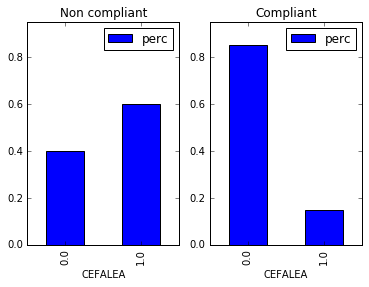

DAY_SOMN
   LABEL  DAY_SOMN  count  perc
0  0     0.000      4     0.267
1  0     1.000      6     0.400
2  0     2.000      3     0.200
3  0     3.000      2     0.133
4  1     0.000      9     0.333
5  1     1.000      5     0.185
6  1     2.000      7     0.259
7  1     3.000      6     0.222
2.37967365967 0.497429579955 ['no']
[ 0.21373737] [ 0.64385373] ['no']


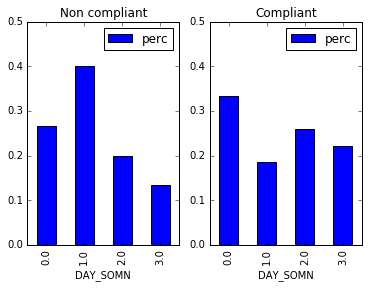

AWAKE_NIGHT
   LABEL  AWAKE_NIGHT  count  perc
0  0     0.000         7     0.467
1  0     1.000         3     0.200
2  0     2.000         4     0.267
3  0     3.000         1     0.067
4  1     0.000         14    0.519
5  1     1.000         2     0.074
6  1     2.000         7     0.259
7  1     3.000         4     0.148
1.87609427609 0.598517570976 ['no']
[ 0.1037037] [ 0.74742952] ['no']


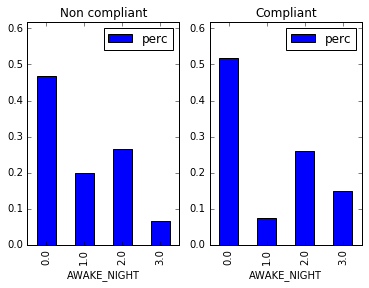

MEM_DIS
   LABEL  MEM_DIS  count  perc
0  0     0.000     9     0.600
1  0     1.000     1     0.067
2  0     2.000     5     0.333
3  1     0.000     18    0.667
4  1     1.000     8     0.296
5  1     2.000     1     0.037
8.36543209877 0.0152570124416 ['yes']
[ 2.54074074] [ 0.11094273] ['no']


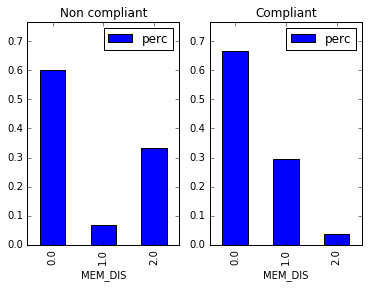

CONC_DIS
   LABEL  CONC_DIS  count  perc
0  0     0.000      9     0.600
1  0     1.000      1     0.067
2  0     2.000      5     0.333
3  1     0.000      20    0.741
4  1     1.000      6     0.222
5  1     2.000      1     0.037
7.60255427842 0.0223422195029 ['yes']
[ 4.07134503] [ 0.04361653] ['yes']


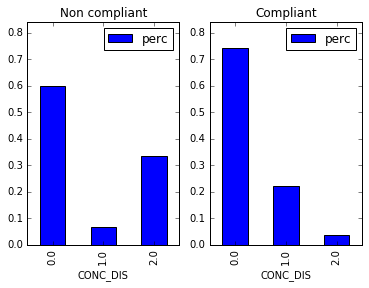

IRR_APAT_DEPRE
   LABEL  IRR_APAT_DEPRE  count  perc
0  0     0.000            5     0.333
1  0     1.000            6     0.400
2  0     2.000            4     0.267
3  1     0.000            18    0.667
4  1     1.000            7     0.259
5  1     2.000            2     0.074
5.07731945993 0.0789721729296 ['no']
[ 4.48088889] [ 0.03427589] ['yes']


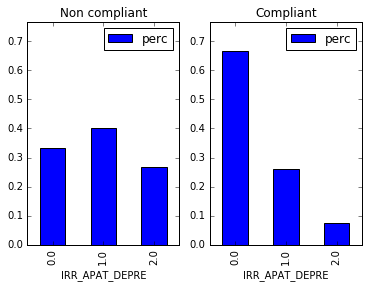

INSOMNIA
   LABEL  INSOMNIA  count  perc
0  0     0.000      10    0.667
1  0     1.000      5     0.333
2  1     0.000      25    0.926
3  1     1.000      2     0.074
2.98666666667 0.0839528182931 ['no']
[ 3.88888889] [ 0.04860657] ['yes']


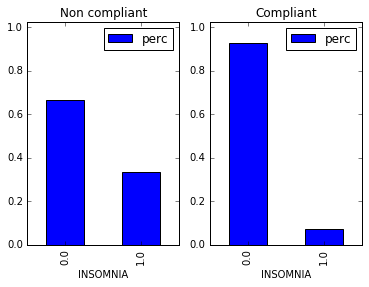

ACT_MOTR_NOCT
   LABEL  ACT_MOTR_NOCT  count  perc
0  0     0.000           9     0.600
1  0     1.000           6     0.400
2  1     0.000           18    0.667
3  1     1.000           9     0.333
0.00921810699588 0.923511857386 ['no']
[ 0.12] [ 0.72903449] ['no']


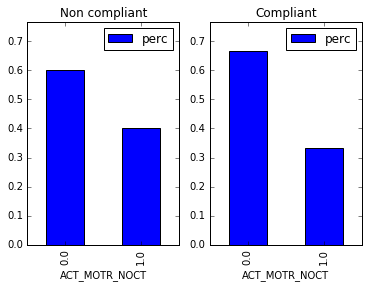

LEG_PAIN_MOVE
   LABEL  LEG_PAIN_MOVE  count  perc
0  0     0.000           13    0.867
1  0     1.000           2     0.133
2  1     0.000           25    0.926
3  1     1.000           2     0.074
0.00614035087719 0.937541380016 ['no']
[ 0.35555556] [ 0.55098499] ['no']


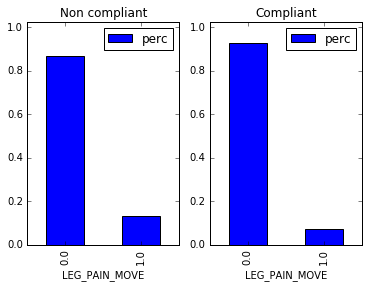

INV_MOV_SLEEP
   LABEL  INV_MOV_SLEEP  count  perc
0  0     0.000           13    0.867
1  0     1.000           2     0.133
2  1     0.000           26    0.963
3  1     1.000           1     0.037
0.287179487179 0.592033676428 ['no']
[ 1.25185185] [ 0.26319908] ['no']


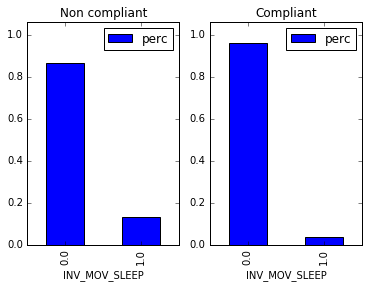

FEEL_REAL_DRE
   LABEL  FEEL_REAL_DRE  count  perc
0  0     0.000           11    0.733
1  0     1.000           4     0.267
2  1     0.000           22    0.815
3  1     1.000           5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


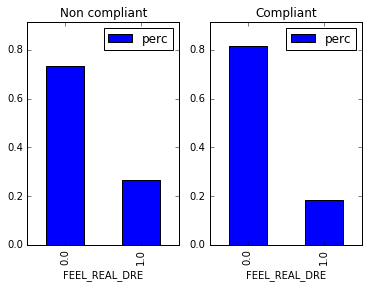

DREAM_INT_PIROSIS
   LABEL  DREAM_INT_PIROSIS  count  perc
0  0     0.000               12    0.800
1  0     1.000               3     0.200
2  1     0.000               21    0.778
3  1     1.000               6     0.222
0.0502805836139 0.822575754748 ['no']
[ 0.02222222] [ 0.88149745] ['no']


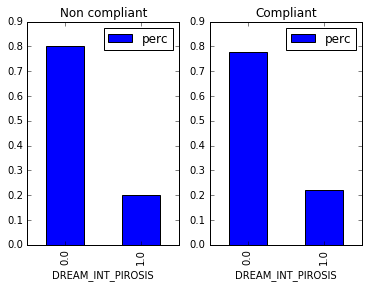

FLEE_TEETH_SLEEP
   LABEL  FLEE_TEETH_SLEEP  count  perc
0  0     0.000              13    0.867
1  0     1.000              2     0.133
2  1     0.000              25    0.926
3  1     1.000              2     0.074
0.00614035087719 0.937541380016 ['no']
[ 0.35555556] [ 0.55098499] ['no']


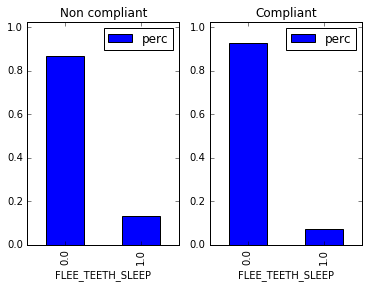

DEC_SEX_DIS
   LABEL  DEC_SEX_DIS  count  perc
0  0     0.000         9     0.600
1  0     1.000         6     0.400
2  1     0.000         16    0.593
3  1     1.000         11    0.407
0.0790588235294 0.77857693838 ['no']
[ 0.00130719] [ 0.97115871] ['no']


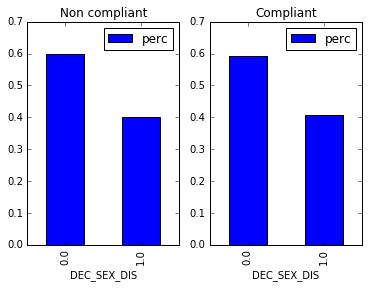

IECAS
   LABEL  IECAS  count  perc
0  0     0.000   13    0.867
1  0     1.000   2     0.133
2  1     0.000   16    0.593
3  1     1.000   11    0.407
2.22811671088 0.135518942157 ['no']
[ 2.34017094] [ 0.12607572] ['no']


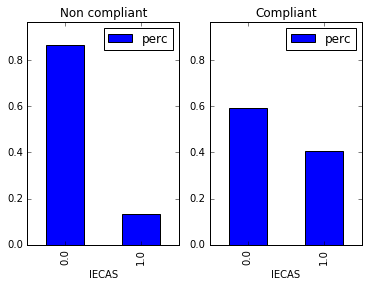

BBLOQ
   LABEL  BBLOQ  count  perc
0  0     0.000   13    0.867
1  0     1.000   2     0.133
2  1     0.000   25    0.926
3  1     1.000   2     0.074
0.00614035087719 0.937541380016 ['no']
[ 0.35555556] [ 0.55098499] ['no']


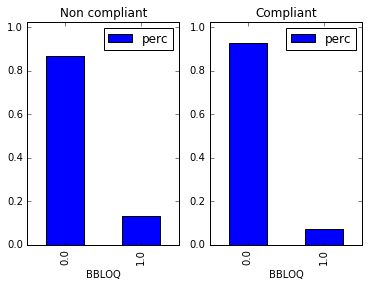

DIURETICS
   LABEL  DIURETICS  count  perc
0  0     0.000       13    0.867
1  0     1.000       2     0.133
2  1     0.000       19    0.704
3  1     1.000       8     0.296
0.65625 0.417886964318 ['no']
[ 1.07555556] [ 0.29969394] ['no']


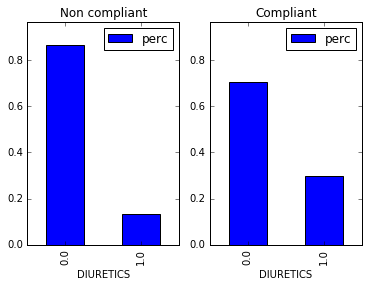

CA-ANTAG
   LABEL  CA-ANTAG  count  perc
0  0     0.000      14    0.933
1  0     1.000      1     0.067
2  1     0.000      23    0.852
3  1     1.000      4     0.148
0.0807207207207 0.776323078135 ['no']
[ 0.53777778] [ 0.46335515] ['no']


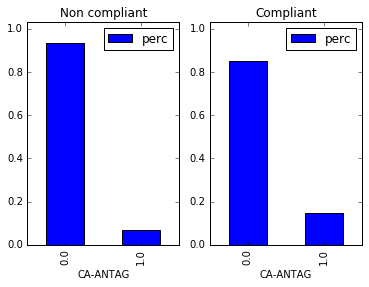

ARA-II
   LABEL  ARA-II  count  perc
0  0     0.000    15    1.000
1  1     0.000    22    0.815
2  1     1.000    5     0.185
1.63459459459 0.20106872754 ['no']
[ 2.77777778] [ 0.0955807] ['no']


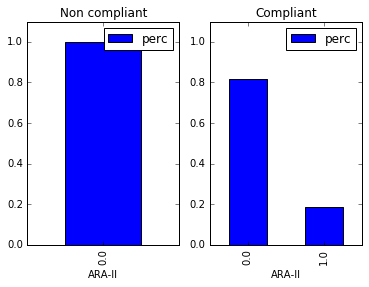

ANTIAGREG
   LABEL  ANTIAGREG  count  perc
0  0     0.000       15    1.000
1  1     0.000       18    0.667
2  1     1.000       9     0.333
4.53782267116 0.0331537369765 ['yes']
[ 5.] [ 0.02534732] ['yes']


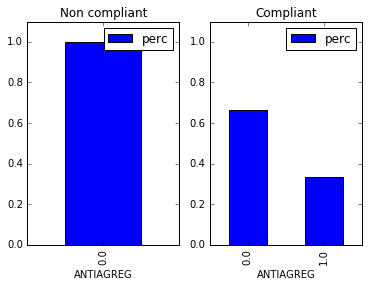

ANTICOAG
   LABEL  ANTICOAG  count  perc
0  0     0.000      13    0.867
1  0     1.000      2     0.133
2  1     0.000      24    0.889
3  1     1.000      3     0.111
0.0807207207207 0.776323078135 ['no']
[ 0.04] [ 0.84148058] ['no']


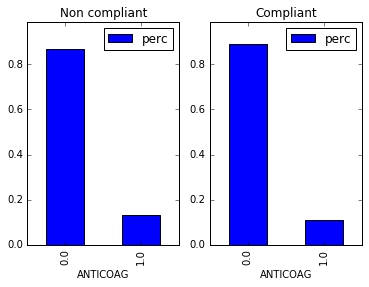

ANTIACID
   LABEL  ANTIACID  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      20    0.741
3  1     1.000      7     0.259
0.00291666666667 0.956930246487 ['no']
[ 0.14222222] [ 0.70608174] ['no']


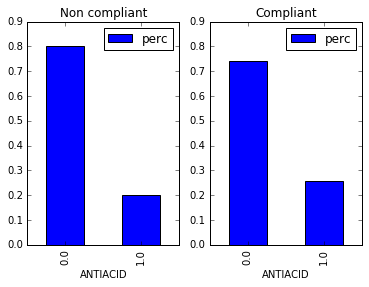

BRONCODIL
   LABEL  BRONCODIL  count  perc
0  0     0.000       14    0.933
1  0     1.000       1     0.067
2  1     0.000       23    0.852
3  1     1.000       4     0.148
0.0807207207207 0.776323078135 ['no']
[ 0.53777778] [ 0.46335515] ['no']


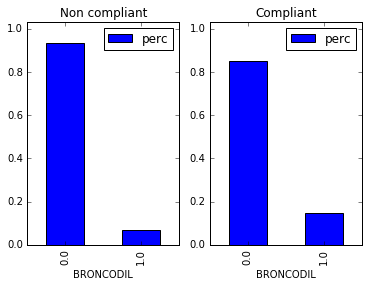

ADO
   LABEL   ADO  count  perc
0  0     0.000  14    0.933
1  0     1.000  1     0.067
2  1     0.000  19    0.704
3  1     1.000  8     0.296
1.8101010101 0.178496113247 ['no']
[ 2.37283951] [ 0.1234623] ['no']


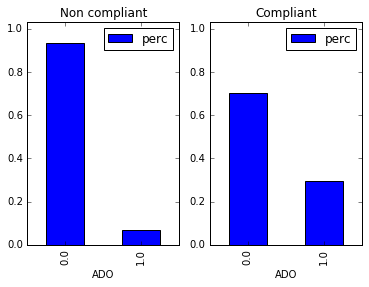

INSULIN
   LABEL  INSULIN  count  perc
0  0     0.000     14    0.933
1  0     1.000     1     0.067
2  1     0.000     24    0.889
3  1     1.000     3     0.111
0.00614035087719 0.937541380016 ['no']
[ 0.2] [ 0.65472085] ['no']


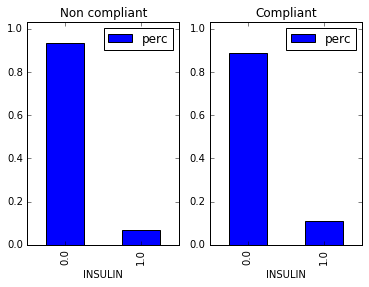

HIPOLIPEM
   LABEL  HIPOLIPEM  count  perc
0  0     0.000       10    0.667
1  0     1.000       5     0.333
2  1     0.000       17    0.630
3  1     1.000       10    0.370
0.00921810699588 0.923511857386 ['no']
[ 0.03703704] [ 0.84738966] ['no']


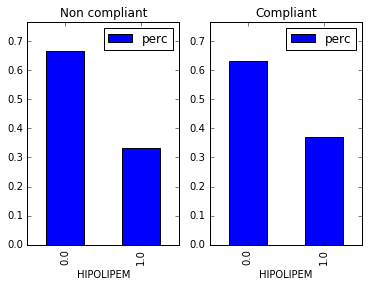

BDZ
   LABEL   BDZ  count  perc
0  0     0.000  11    0.733
1  0     1.000  4     0.267
2  1     0.000  24    0.889
3  1     1.000  3     0.111
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


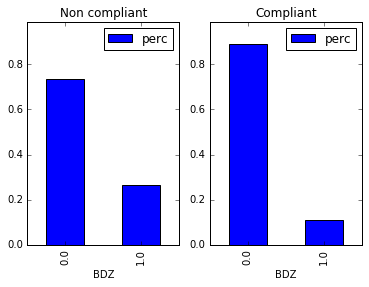

ANTIDEPRE
   LABEL  ANTIDEPRE  count  perc
0  0     0.000       14    0.933
1  0     1.000       1     0.067
2  1     0.000       21    0.778
3  1     1.000       6     0.222
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


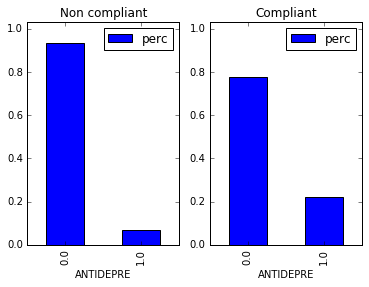

OTHER_PSICO
   LABEL  OTHER_PSICO  count  perc
0  0     0.000         12    0.800
1  0     1.000         3     0.200
2  1     0.000         25    0.926
3  1     1.000         2     0.074
0.504504504505 0.477527540472 ['no']
[ 1.28444444] [ 0.2570743] ['no']


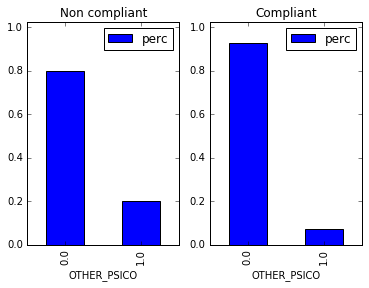

OTHER_HIPOT
   LABEL  OTHER_HIPOT  count  perc
0  0     0.000         14    0.933
1  0     1.000         1     0.067
2  1     0.000         26    0.963
3  1     1.000         1     0.037
0.105 0.745909995805 ['no']
[ 0.17777778] [ 0.67328998] ['no']


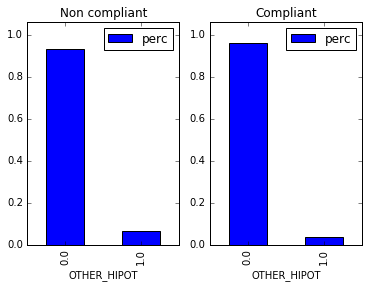

In [774]:
from scipy.stats import chisquare

for i in range(len(catCols)):
    if catCols[i] == 1:
                
        gr = dfImputed.groupby(["LABEL",dfImputed.columns[i]]).count().iloc[:,:1].reset_index()
        gr["count"] = gr.iloc[:,2]
        gr["perc"] = 0.0
        for j in range(gr.shape[0]):
            if gr["LABEL"].iloc[j] == 0:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 0]["count"].sum()))
            else:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 1]["count"].sum()))

        #Significance tests
        r1, p1 = chi2(dfImputed.iloc[:,i].values.astype(int).reshape(-1,1),dfImputed["LABEL"].values.astype(int).reshape(-1,1))        
        r,p,df,kounts = chi_square_of_df_cols(dfImputed, dfImputed.columns[i], 'LABEL')
        
        #if p < 0.05 or p1 < 0.05:
            
        sigArr.append([dfImputed.columns[i], p, p1[0], "cat"])
        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL", dfImputed.columns[i], "count","perc"]]            
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        gr[gr.LABEL == 0].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")

        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        gr[gr.LABEL == 1].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")
        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Compliant")
        plt.show()


#### Numerical data

AGE
   LABEL   mean    std    max    min  count
0 0.000  51.467 12.705 71.000 33.000 15.000
1 1.000  59.963 11.650 81.000 40.000 27.000
[ 1687.54068488] [ 0.] ['yes']
[ 41.07968701] [ 0.] ['yes']
0.0 4.32526922354e-16 ['yes']


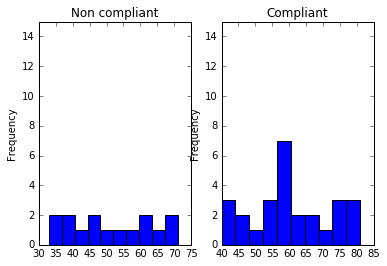

SMOKE_PACK_YEAR
   LABEL    mean     std       max   min  count
0 0.000  139.667 228.694 730.000   0.000 15.000
1 1.000  159.704 269.319 1,095.000 0.000 27.000
[ 14.96710328] [ 0.00021848] ['yes']
[ 3.86873407] [ 0.00021848] ['yes']
793.5 0.199856359845 ['no']


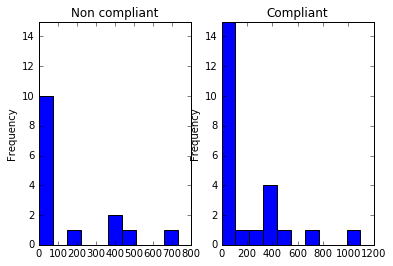

SMOKE_EX_YEAR
   LABEL  mean   std    max   min  count
0 0.000  0.733 2.086 8.000  0.000 15.000
1 1.000  3.787 6.525 20.000 0.000 27.000
[ 0.0648089] [ 0.79968801] ['no']
[-0.25457591] [ 0.79968801] ['no']
682.5 0.0248686589155 ['yes']


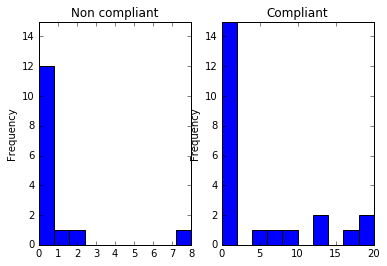

ALCOHOL_GR_DAY
   LABEL  mean    std    max   min  count
0 0.000  4.333 10.499 40.000 0.000 15.000
1 1.000  4.354 8.694  40.000 0.000 27.000
[ 0.48423456] [ 0.48847808] ['no']
[ 0.69586964] [ 0.48847808] ['no']
759.0 0.117314849469 ['no']


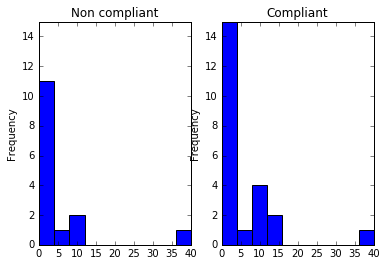

CAFES_DAY
   LABEL  mean   std   max   min  count
0 0.000  1.667 1.345 5.000 0.000 15.000
1 1.000  1.185 1.265 4.500 0.000 27.000
[ 0.27794834] [ 0.59947261] ['no']
[ 0.52720806] [ 0.59947261] ['no']
726.0 0.0736777645431 ['no']


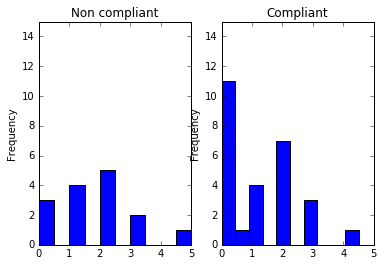

SLEEP_TIME
   LABEL    mean    std     max     min  count
0 0.000  391.917 75.338 499.000 238.000 15.000
1 1.000  388.556 74.005 500.000 173.000 27.000
[ 4194.77112007] [ 0.] ['yes']
[ 64.76705274] [ 0.] ['yes']
0.0 4.355301361e-16 ['yes']


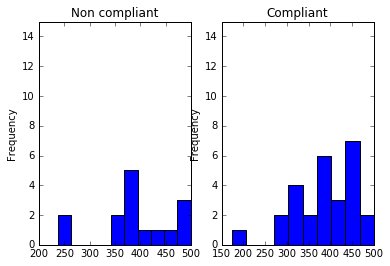

IAH
   LABEL   mean    std    max    min  count
0 0.000  46.609 18.965 79.070 15.500 15.000
1 1.000  56.754 21.484 94.500 22.900 27.000
[ 1089.29537087] [ 0.] ['yes']
[ 33.00447501] [ 0.] ['yes']
0.0 4.35831532601e-16 ['yes']


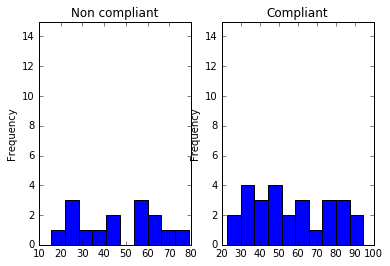

TIME_SAT<90%
   LABEL   mean    std     max   min  count
0 0.000  56.565 83.999 299.200 1.970 15.000
1 1.000  70.157 71.691 282.500 0.900 27.000
[ 188.26793079] [ 0.] ['yes']
[ 13.72107615] [ 0.] ['yes']
27.0 3.14936988134e-15 ['yes']


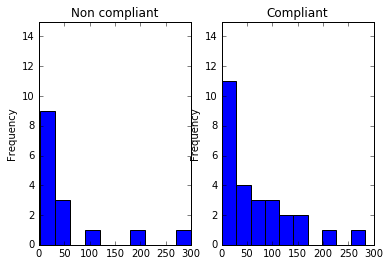

CT90%
   LABEL   mean    std    max   min  count
0 0.000  14.018 18.211 66.000 0.800 15.000
1 1.000  23.044 25.111 92.000 0.900 27.000
[ 97.1538277] [ 0.] ['yes']
[ 9.85666413] [ 0.] ['yes']
54.0 2.14013430154e-14 ['yes']


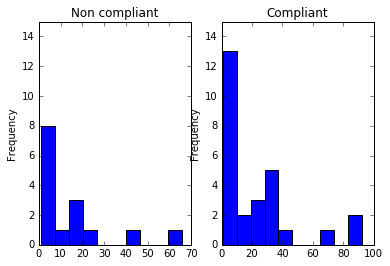

IND_DESAT
   LABEL   mean    std    max   min  count
0 0.000  36.229 21.290 72.200 6.380 15.000
1 1.000  41.045 27.670 90.700 1.970 27.000
[ 313.26376506] [ 0.] ['yes']
[ 17.69925888] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


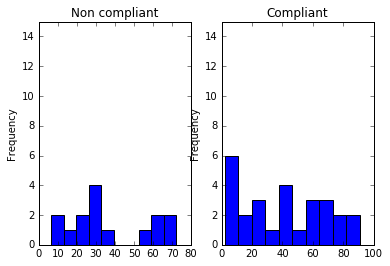

WEIGHT
   LABEL   mean    std     max    min  count
0 0.000  90.320 20.284 134.000 61.000 15.000
1 1.000  95.937 14.085 122.500 65.500 27.000
[ 2386.21177808] [ 0.] ['yes']
[ 48.8488667] [ 0.] ['yes']
0.0 4.33126004129e-16 ['yes']


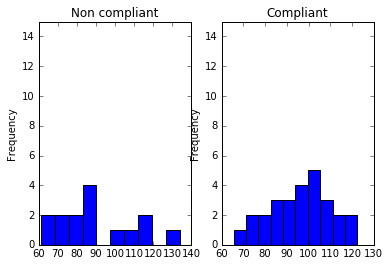

SIZE
   LABEL  mean   std   max   min  count
0 0.000  1.657 0.109 1.920 1.500 15.000
1 1.000  1.675 0.095 1.830 1.500 27.000
[ 20.27558395] [ 0.00002198] ['yes']
[ 4.50284176] [ 0.00002198] ['yes']
783.0 0.184339347156 ['no']


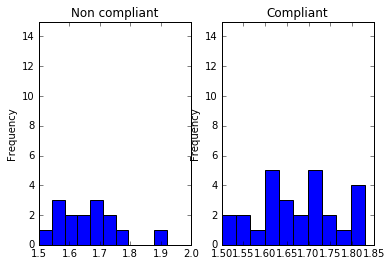

BMI
   LABEL   mean   std    max    min  count
0 0.000  33.150 8.163 50.220 23.330 15.000
1 1.000  34.214 5.438 44.780 23.390 27.000
[ 1307.36412262] [ 0.] ['yes']
[ 36.15749055] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


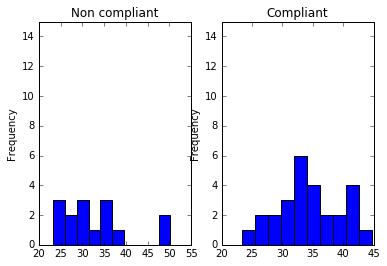

CIRC_NECK
   LABEL   mean   std    max    min  count
0 0.000  43.067 5.216 53.000 35.000 15.000
1 1.000  42.222 3.776 50.000 35.000 27.000
[ 1675.63906758] [ 0.] ['yes']
[ 40.93457057] [ 0.] ['yes']
0.0 4.19251643379e-16 ['yes']


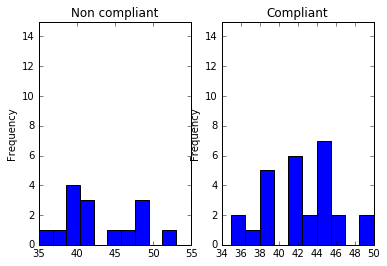

CIRC_ABD
   LABEL    mean    std     max    min  count
0 0.000  104.067 17.470 138.000 82.000 15.000
1 1.000  112.296 12.015 132.000 83.000 27.000
[ 2722.80900988] [ 0.] ['yes']
[ 52.18054245] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


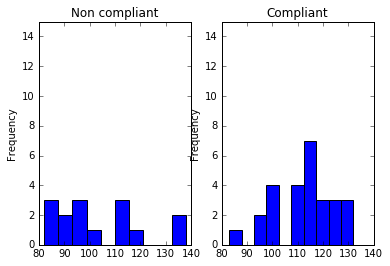

CIRC_HIP
   LABEL    mean    std     max    min  count
0 0.000  106.267 13.630 139.000 92.000 15.000
1 1.000  111.074 12.536 132.000 85.000 27.000
[ 2776.92425071] [ 0.] ['yes']
[ 52.69652978] [ 0.] ['yes']
0.0 4.32227673499e-16 ['yes']


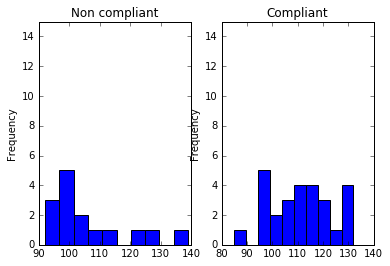

TAS_MEAN
   LABEL    mean    std     max     min  count
0 0.000  129.733 16.662 167.000 106.000 15.000
1 1.000  141.981 21.572 192.000 93.500  27.000
[ 2984.00196852] [ 0.] ['yes']
[ 54.62601915] [ 0.] ['yes']
0.0 4.3492793048e-16 ['yes']


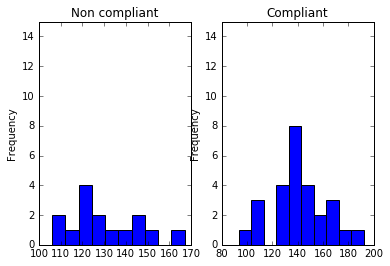

TAD_MEAN
   LABEL   mean    std     max    min  count
0 0.000  84.600 10.105 104.500 65.000 15.000
1 1.000  88.333 17.143 127.500 59.000 27.000
[ 2328.97851711] [ 0.] ['yes']
[ 48.25949147] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


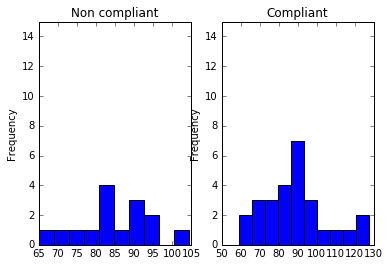

SAT_O2
   LABEL   mean   std    max    min  count
0 0.000  97.933 0.704 99.000 96.000 15.000
1 1.000  97.148 1.769 99.000 93.000 27.000
[ 2778.24041475] [ 0.] ['yes']
[ 52.70901645] [ 0.] ['yes']
0.0 2.06115961466e-16 ['yes']


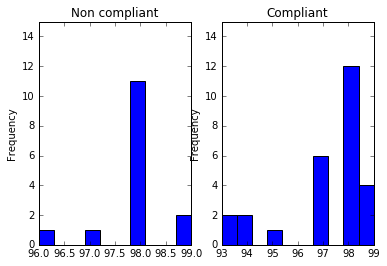

PRESS_CPAP
   LABEL   mean   std    max   min  count
0 0.000  10.760 1.233 13.000 8.000 15.000
1 1.000  11.015 1.153 14.000 9.000 27.000
[ 574.56990056] [ 0.] ['yes']
[ 23.97018775] [ 0.] ['yes']
0.0 3.3005819816e-16 ['yes']


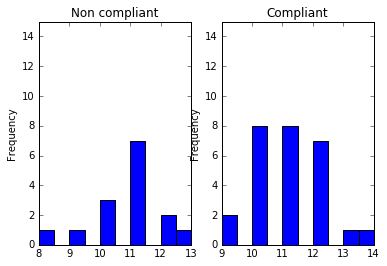

EPWORTH
   LABEL  mean   std    max   min  count
0 0.000  9.267 4.448 17.000 2.000 15.000
1 1.000  8.607 4.908 18.000 0.000 27.000
[ 144.48677922] [ 0.] ['yes']
[ 12.02026536] [ 0.] ['yes']
61.5 3.42067658337e-14 ['yes']


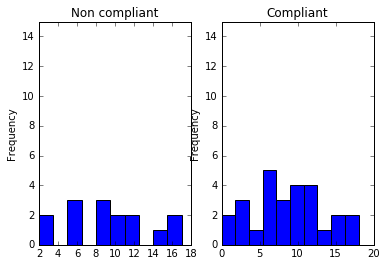

EUROQOL
   LABEL  mean   std   max   min  count
0 0.000  0.796 0.236 1.000 0.130 15.000
1 1.000  0.782 0.216 1.000 0.374 27.000
[ 0.82221981] [ 0.36718888] ['no']
[-0.90676337] [ 0.36718888] ['no']
630.0 0.0105804702212 ['yes']


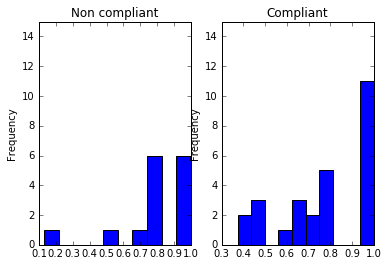

VISUAL
   LABEL   mean    std     max    min  count
0 0.000  64.000 18.146 90.000  40.000 15.000
1 1.000  54.852 25.665 100.000 5.000  27.000
[ 812.44457106] [ 0.] ['yes']
[ 28.50341332] [ 0.] ['yes']
0.0 3.63094837081e-16 ['yes']


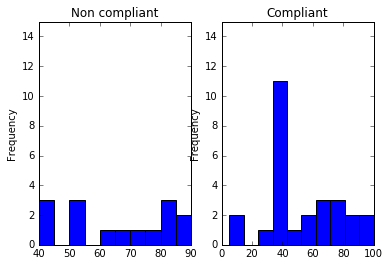

In [780]:
from scipy import stats

for i in range(len(catCols)):
    if catCols[i] == 0:

        r, p = f_oneway(np.log((dfImputed.iloc[:,i].values.astype(float)+1.0).reshape(-1,1)),dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r1, p1 = stats.ttest_ind(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r2, p2 = stats.mannwhitneyu(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
           
        #if p < 0.05 or p1 < 0.05:
                    
        gr = dfImputed[["LABEL",dfImputed.columns[i]]].groupby(["LABEL"]).agg({"std","mean","count","min","max"}).iloc[:,:6].reset_index()
        gr = pd.DataFrame(gr.values, columns=["LABEL","std","count","max","min","mean"])

        sigArr.append([dfImputed.columns[i], p1[0], p2, "num"])

        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL","mean","std","max","min","count"]]
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]            
        print r2, p2, ["yes" if p2 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        dfImputed[dfImputed.LABEL == 0][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        dfImputed[dfImputed.LABEL == 1][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Compliant")
        plt.show()

In [781]:
print len(sigArr)
dfSigArr = pd.DataFrame(sigArr, columns=["column","pval","pval1","type"])
dfSigArr

168


,column,pval,pval1,type
0,GENDER,0.921,0.890,cat
1,ACTIVE,0.779,0.698,cat
2,NO_ACTIVE,0.779,0.638,cat
3,RETIRED,0.733,0.577,cat
4,SMOKER,0.887,0.881,cat
5,ALCOHOL,0.546,0.482,cat
6,DEPRESSION,0.388,0.237,cat
7,ANXIETY,0.823,0.585,cat
8,HTA,0.024,0.101,cat
9,CARDIOPATHY,0.575,0.439,cat


### Clean features (optional)

In [730]:
df_all = df_all[df_all.columns[~df_all.columns.isin(to_del)]]
catCols = catCols[~dfImputed.columns[:-1].isin(to_del)]
dfImputed = dfImputed[dfImputed.columns[:-1][~dfImputed.columns[:-1].isin(to_del)]]
columns = df_all.columns

print len(columns)
print catCols.shape
print df_all.shape
print dfImputed.shape

55
(54,)
(42, 55)
(42, 54)


In [735]:
dfImputed.columns

Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL'],
      dtype='object')

### SAVE filtered data

In [731]:
print index

if index == 0:
    fileName = os.path.join('resources','data_filtered_cl0_short_no_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl')
elif index == 1:
    fileName = os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016_final.pkl')
else:
    fileName = os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')

df_all_codes = df_all.copy()
df_all_codes.insert(0,"CODIGO", codes)
df_all_codes.to_pickle(fileName)
print df_all.shape

#save feature mapping 
dfFeatures.to_pickle(fileName1)
print dfFeatures.shape

0
(42, 55)
(77, 6)


### 3. M0 final dataset (after preprocessing: imputation, relabel categories, remove features,...)

In [732]:
print len(df_all.columns[catCols==1]), df_all.columns[catCols==1]

dfCat_1 = dfCatSum[dfCatSum.variable.isin(df_all.columns[catCols==1])]
dfCat_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==1])]
dfCatFinal = pd.merge(dfCat_1, dfCat_2,left_on="variable", right_on="column")
dfCatFinal["sig."] = dfCatFinal.pval < 0.05
types = []
for n in dfCatFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfCatFinal["type"] = types

pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCatFinal[dfCatFinal.type.isin(["CLINICAL_HISTORY","COMORBIDITIES"])][["variable", "type","categories", "frequencies","ratios", "pval","sig."]].to_html(index=False)))
display(HTML(dfCatFinal[dfCatFinal.type.isin(["SYMPTOMS","THERAPY"])][["variable", "type","categories", "frequencies","ratios", "pval","sig."]].to_html(index=False)))

35 Index([u'GENDER', u'ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL', u'DEPRESSION',
       u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS', u'DIABETES',
       u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ'],
      dtype='object')


variable,type,categories,frequencies,ratios,pval,sig.
GENDER,CLINICAL_HISTORY,"[1.0, 0.0]","[29, 13]","[0.69, 0.31]",0.921,False
ACTIVE,CLINICAL_HISTORY,"[1.0, 0.0]","[25, 17]","[0.6, 0.4]",0.779,False
RETIRED,CLINICAL_HISTORY,"[0.0, 1.0]","[28, 14]","[0.67, 0.33]",0.733,False
SMOKER,CLINICAL_HISTORY,"[0.0, 1.0]","[26, 16]","[0.62, 0.38]",0.887,False
ALCOHOL,CLINICAL_HISTORY,"[0.0, 1.0]","[24, 18]","[0.57, 0.43]",0.546,False
DEPRESSION,COMORBIDITIES,"[0.0, 1.0]","[35, 7]","[0.83, 0.17]",0.388,False
ANXIETY,COMORBIDITIES,"[0.0, 1.0]","[33, 9]","[0.79, 0.21]",0.823,False
HTA,COMORBIDITIES,"[1.0, 0.0]","[25, 17]","[0.6, 0.4]",0.024,True
CARDIOPATHY,COMORBIDITIES,"[0.0, 1.0]","[30, 12]","[0.71, 0.29]",0.575,False
RESP_DIS,COMORBIDITIES,"[0.0, 1.0]","[31, 11]","[0.74, 0.26]",0.754,False


variable,type,categories,frequencies,ratios,pval,sig.
SNORES,SYMPTOMS,"[1.0, 0.0]","[29, 13]","[0.69, 0.31]",0.550,False
REP_SLEEP,SYMPTOMS,"[2.0, 0.0, 1.0, 3.0]","[19, 11, 7, 5]","[0.45, 0.26, 0.17, 0.12]",0.831,False
CRISIS_ASP,SYMPTOMS,"[0.0, 1.0, 2.0]","[24, 14, 4]","[0.57, 0.33, 0.1]",0.247,False
NOCTURIA,SYMPTOMS,"[3.0, 1.0, 0.0, 2.0]","[16, 12, 9, 5]","[0.38, 0.29, 0.21, 0.12]",0.762,False
APNEAS_PRES,SYMPTOMS,"[2.0, 0.0, 1.0, 3.0]","[13, 10, 10, 9]","[0.31, 0.24, 0.24, 0.21]",0.610,False
CEFALEA,SYMPTOMS,"[0.0, 1.0]","[29, 13]","[0.69, 0.31]",0.007,True
DAY_SOMN,SYMPTOMS,"[0.0, 1.0, 2.0, 3.0]","[13, 11, 10, 8]","[0.31, 0.26, 0.24, 0.19]",0.497,False
AWAKE_NIGHT,SYMPTOMS,"[0.0, 2.0, 3.0, 1.0]","[21, 11, 5, 5]","[0.5, 0.26, 0.12, 0.12]",0.599,False
CONC_DIS,SYMPTOMS,"[0.0, 1.0, 2.0]","[29, 7, 6]","[0.69, 0.17, 0.14]",0.022,True
IRR_APAT_DEPRE,SYMPTOMS,"[0.0, 1.0, 2.0]","[23, 13, 6]","[0.55, 0.31, 0.14]",0.079,False


In [734]:
print len(df_all.columns[catCols==0]), df_all.columns[catCols==0]

dfNum_1 = dfImputed[dfImputed.columns[catCols==0]].describe().T
dfNum_1["variable"] = dfNum_1.index

dfNum_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==0])]
dfNumFinal = pd.merge(dfNum_1, dfNum_2, left_on="variable", right_on="column")
dfNumFinal["sig."] = dfNumFinal.pval1 < 0.05

types = []
for n in dfNumFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfNumFinal["type"] = types
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfNumFinal[["variable","type","mean","std","max","25%","50%","75%","pval1","sig."]].to_html(index=False)))

19 Index([u'AGE', u'SMOKE_PACK_YEAR', u'SMOKE_EX_YEAR', u'ALCOHOL_GR_DAY',
       u'CAFES_DAY', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%', u'IND_DESAT',
       u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN', u'SAT_O2',
       u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL'],
      dtype='object')


variable,type,mean,std,max,25%,50%,75%,pval1,sig.
AGE,CLINICAL_HISTORY,56.929,12.576,81.000,48.000,57.000,65.000,0.000,True
SMOKE_PACK_YEAR,CLINICAL_HISTORY,152.548,252.883,"1,095.000",0.000,0.000,342.250,0.000,True
SMOKE_EX_YEAR,CLINICAL_HISTORY,2.696,5.539,20.000,0.000,0.000,1.000,0.800,False
ALCOHOL_GR_DAY,CLINICAL_HISTORY,4.347,9.251,40.000,0.000,0.000,5.000,0.488,False
CAFES_DAY,CLINICAL_HISTORY,1.357,1.299,5.000,0.000,1.000,2.000,0.599,False
SLEEP_TIME,SLEEP_TEST,389.756,73.578,500.000,348.750,392.000,452.250,0.000,True
IAH,SLEEP_TEST,53.131,20.970,94.500,37.185,52.945,65.600,0.000,True
TIME_SAT<90%,SLEEP_TEST,65.303,75.578,299.200,14.000,31.500,92.412,0.000,True
IND_DESAT,SLEEP_TEST,39.325,25.412,90.700,19.790,34.600,61.317,0.000,True
SIZE,BASAL,1.668,0.099,1.920,1.593,1.665,1.730,0.000,True


### 4. Multivariate analysis

In [736]:
scaler = preprocessing.StandardScaler().fit(dfImputed)
df_all_scaled = scaler.transform(dfImputed)
df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, df_all.iloc[:,-1].reshape(-1,1))), 
    columns = columns)
df_all_scaled["LABEL"] = pd.to_numeric(df_all_scaled["LABEL"])

print df_all_scaled.shape
print df_all_scaled.columns
print df_all_scaled.iloc[:,-1].values

(42, 55)
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL', u'LABEL'],
      dtype='object')
[ 0.    6.5   5.    7.    5.    7.    4.    4.5   7.5   3.32  6.5   3.5
  6.51  6.5   6.    0.    8.    5.5   3.93  3.5   7.    4.99  7.5   4.   

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [737]:
pca = PCA()
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)
print "DATASET: {}M".format(index)
print('explained variance ratio (first components): %s'
      % str(pca.explained_variance_ratio_))
print "explained variance ratio of 2 pcas:", np.sum(pca.explained_variance_ratio_[:2])

DATASET: 0M
explained variance ratio (first components): [ 0.1183258   0.09544672  0.08833869  0.06549769  0.05467642  0.05136407
  0.04714502  0.04573329  0.04303517  0.03717131  0.03476523  0.03188419
  0.02942565  0.02730524  0.0245016   0.0229694   0.02140975  0.01861184
  0.01618337  0.01508887  0.01388115  0.01220311  0.01128375  0.01013743
  0.00952726  0.00818827  0.00693214  0.00676051  0.00568797  0.00526577
  0.00445086  0.0036296   0.00331515  0.00286365  0.00197008  0.00148768
  0.0013667   0.00087334  0.00063981  0.00040516  0.00025129  0.        ]
explained variance ratio of 2 pcas: 0.213772520849


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


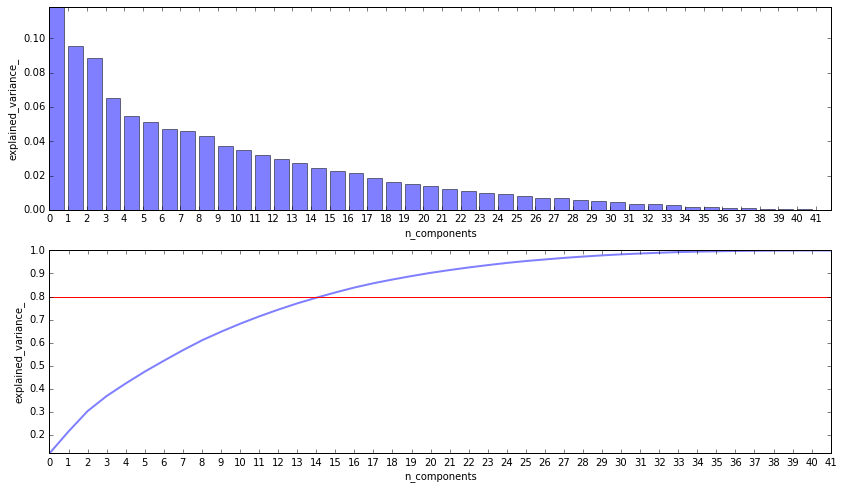

In [738]:
plt.figure(1, figsize=(14, 8))
#plt.clf()
#plt.axes([.2, .2, .7, .7])
ax = plt.subplot(2,1,1)
ax.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, alpha=0.5)#, linewidth=2)
ax.axis('tight')
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_')
plt.xticks(range(len(pca.explained_variance_ratio_)),range(len(pca.explained_variance_ratio_)))


#plt.figure(1, figsize=(14, 4))
#plt.clf()
#plt.axes([.2, .2, .7, .7])
ax = plt.subplot(2,1,2)
ax.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), linewidth=2, alpha=0.5)
ax.axhline(0.8,c="r")
ax.axis('tight')
ax.set_xlabel('n_components')
ax.set_ylabel('explained_variance_')
plt.xticks(range(len(pca.explained_variance_ratio_)),range(len(pca.explained_variance_ratio_)))
plt.show()


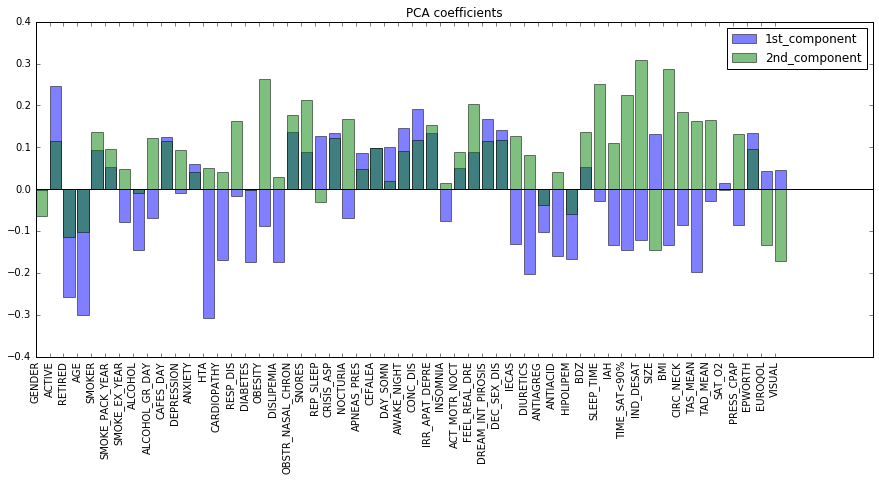

In [739]:
#Plot pca's coefficients
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.bar(range(pca.components_.shape[1]), pca.components_[0,:],label="1st_component", alpha=0.5)
ax.bar(range(pca.components_.shape[1]), pca.components_[1,:],label="2nd_component", alpha=0.5)
ax.axhline(y=0,c="black")
plt.xticks(range(pca.components_.shape[1]),df_all_scaled.columns,rotation=90)
plt.title("PCA coefficients")
plt.legend()
plt.show()

In [740]:
classes = [0,1]
colors = ["r","g"]


0 Non compliant (<= 3.5) 9 (42, 55) (42, 42)
1 Compliant (> 3.5) 33 (42, 55) (42, 42)

0 Non compliant (<= 3.9) 10 (42, 55) (42, 42)
1 Compliant (> 3.9) 32 (42, 55) (42, 42)

0 Non compliant (<= 4.0) 15 (42, 55) (42, 42)
1 Compliant (> 4.0) 27 (42, 55) (42, 42)

0 Non compliant (<= 4.2) 15 (42, 55) (42, 42)
1 Compliant (> 4.2) 27 (42, 55) (42, 42)

0 Non compliant (<= 4.5) 17 (42, 55) (42, 42)
1 Compliant (> 4.5) 25 (42, 55) (42, 42)

0 Non compliant (<= 5.0) 20 (42, 55) (42, 42)
1 Compliant (> 5.0) 22 (42, 55) (42, 42)


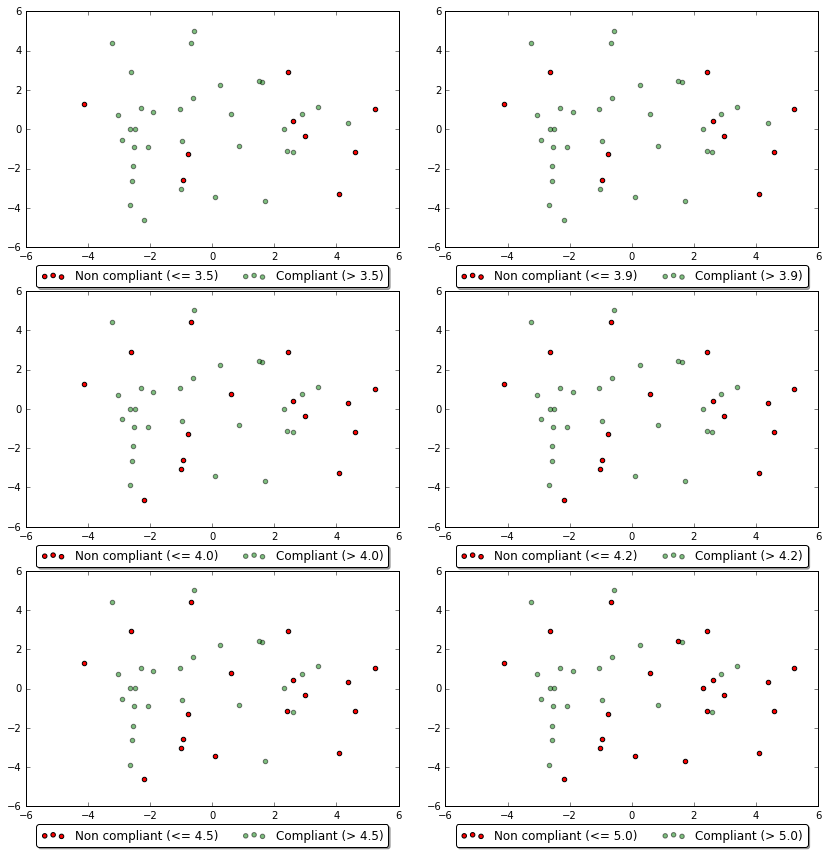

(6, 2)


In [741]:
#Label differences
arr = []
fig = plt.figure(figsize=(12,12))
for t,thr in enumerate(thrs):
    
    target_names = ["Non compliant (<= {})".format(thr), "Compliant (> {})".format(thr)]
    arr.append([np.sum(df_all_scaled.ix[:,-1] <= thr), np.sum(df_all_scaled.ix[:,-1] > thr)])

    for c in classes:
        ax = plt.subplot(round(len(thrs)/2.0),2,t+1)

        if c == 0:
            print "\n",c, target_names[c], np.sum(df_all_scaled.iloc[:,-1].values.astype(float) <= float(thr)), \
                    df_all_scaled.shape, X_r.shape
            
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 1], 
                        c=colors[c], label=target_names[c])
        else:
            print c, target_names[c], np.sum(df_all_scaled.iloc[:,-1].values.astype(float) > float(thr)), \
                    df_all_scaled.shape, X_r.shape        
            
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 1], 
                        c=colors[c], label=target_names[c], alpha=0.5)
        
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
            
plt.tight_layout(pad=2.5)
plt.show()

arr = np.array(arr)
print arr.shape

[33 32 27 27 25 22]


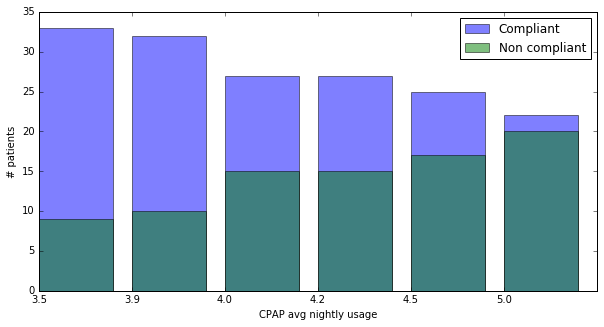

In [47]:
print arr[:,1]

plt.figure(figsize=(10,5))
plt.bar(range(len(arr[:,1])), arr[:,1],label="Compliant", alpha=0.5)
plt.bar(range(len(arr[:,1])), arr[:,0],label="Non compliant", alpha=0.5)

plt.xticks(range(len(thrs)), thrs)
plt.legend()
plt.ylabel("# patients")
plt.xlabel("CPAP avg nightly usage")
plt.show()

#### PCA on numerical data

0 EDAD 48.0 57.0 65.0 [ 0.  1.  2.] 12 20 10
1 FUMA_PAQ_ANY 0.0 0.0 342.25 [ 0.  1.  2.] 23 8 11
2 HTA 0.0 1.0 1.0 [ 0.  1.] 17 25 0
3 CEFALEA 0.0 0.0 1.0 [ 0.  1.] 29 13 0
4 TRAST_CONC 0.0 0.0 1.0 [ 0.  1.  2.] 29 7 6
5 IRR_APAT_DEPR 0.0 0.0 1.0 [ 0.  1.  2.] 23 13 6
6 INSOMNIO 0.0 0.0 0.0 [ 0.  2.] 35 0 7
7 ANTIAGREG 0.0 0.0 0.0 [ 0.  2.] 33 0 9
8 TIEMP_SUENO 348.75 392.0 452.25 [ 0.  1.  2.] 11 20 11
9 IAH 37.185 52.945 65.6 [ 0.  1.  2.] 11 20 11
10 TIEMPOSAT<90% 14.0 31.5 92.4125 [ 0.  1.  2.] 13 18 11
11 IND_DESAT 19.79 34.6 61.3175 [ 0.  1.  2.] 11 20 11
12 TALLA 1.5925 1.665 1.73 [ 0.  1.  2.] 11 21 10
13 IMC 29.6925 33.325 37.05 [ 0.  1.  2.] 11 20 11
14 CIRC_CUELLO 39.0 42.0 45.0 [ 0.  1.  2.] 12 21 9
15 MEDIA_TAS 124.375 137.75 149.375 [ 0.  1.  2.] 11 20 11
16 MEDIA_TAD 77.625 86.5 94.875 [ 0.  1.  2.] 11 20 11
17 Sat O2 97.0 98.0 98.0 [ 0.  1.  2.] 13 23 6
18 PRESS_CPAP 10.0 11.0 12.0 [ 0.  1.  2.] 15 24 3
19 EPWORTH 6.0 9.0 12.0 [ 0.  1.  2.] 15 19 8
20 VISUAL 40.0 55.0 8

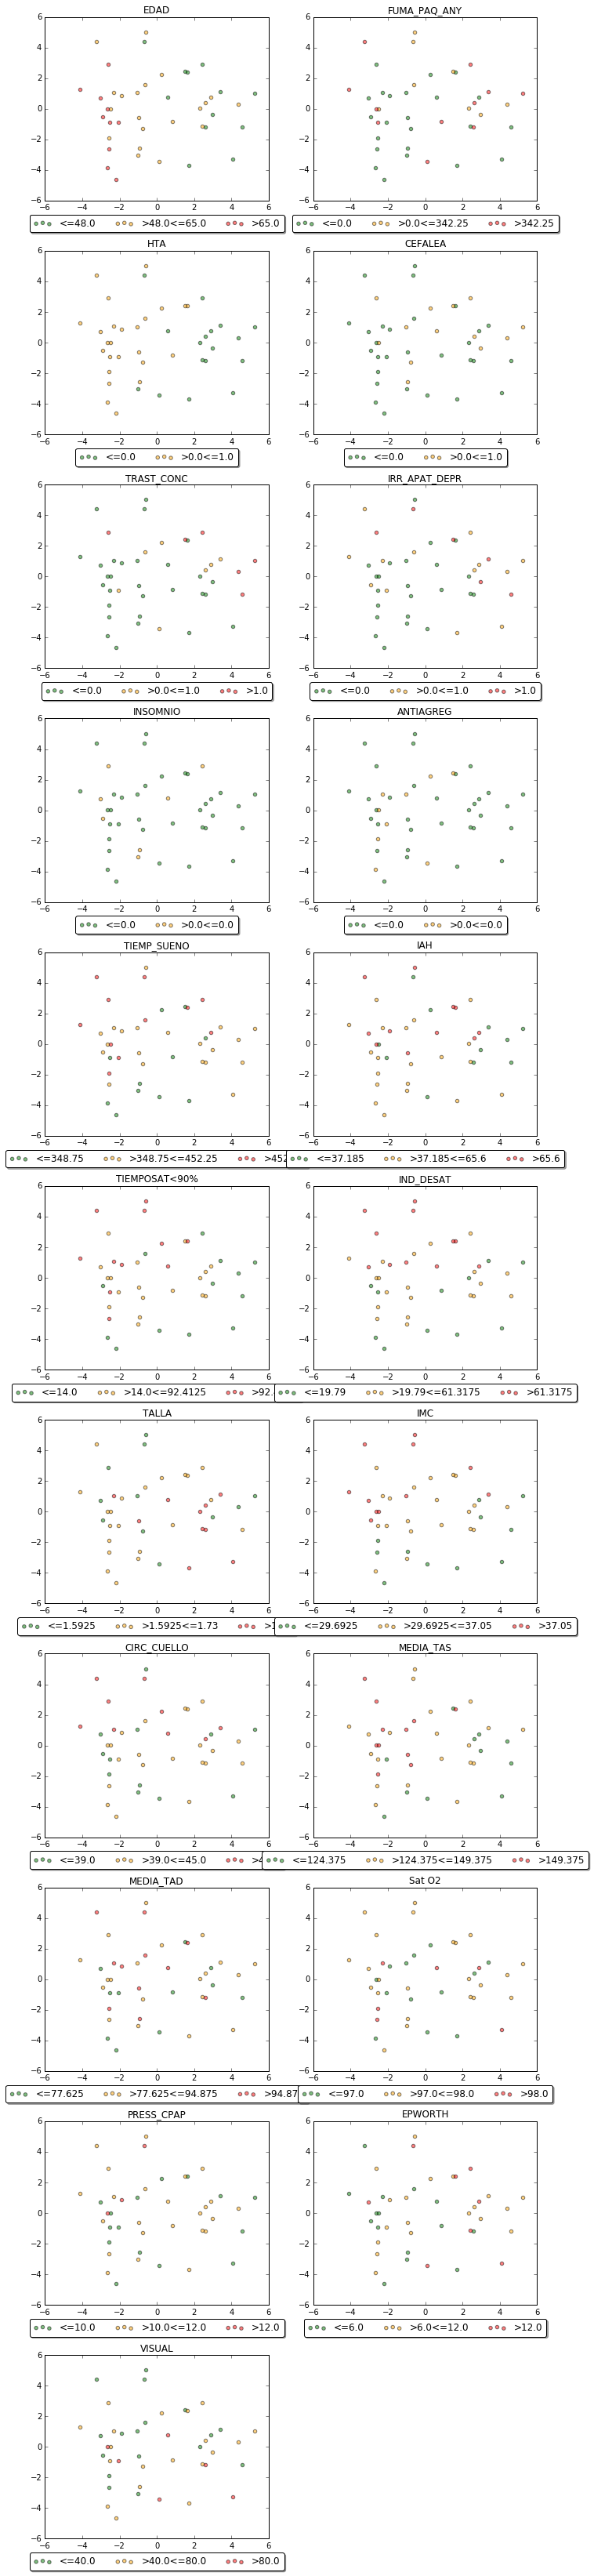

In [49]:
fig = plt.figure(1, figsize=(10, 50))
#plt.grid(visible=False)

k = 0
for i,c in enumerate(df_all_scaled.columns):
        
    if c in dfSigArr["column"].values: # dfNorm[dfNorm.variable == c][["categoric"]].values == "no":
        val_tmp = dfImputed[c].copy()
        values = dfImputed[c].copy()
        p25 = values.quantile(0.25)
        p50 = values.quantile(0.5)
        p75 = values.quantile(0.75)


        values[val_tmp<=p25] = 0
        values[np.logical_and(val_tmp>p25,val_tmp<=p75)] = 1
        values[val_tmp>p75] = 2
        strLabels = ["<=" + str(p25), ">"+str(p25)+"<="+str(p75), ">" + str(p75)]
        labels = np.unique(values)
        print k, c, p25, p50, p75, labels, np.sum(values==0), np.sum(values==1), np.sum(values==2)
        
        cs = ["green", "orange", "red"]
        ax = plt.subplot(12,2,k+1)
        for i,l in enumerate(labels):
                ax.scatter(X_r[np.where(values==l)[0], 0], X_r[np.where(values==l)[0], 1], 
                           label = strLabels[i], c=cs[i], alpha=0.5)
        ax.set_title(c)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=3)
        k += 1

        
plt.tight_layout(pad=3.5)
plt.show()

#### Clustering

In [50]:
from sklearn import metrics
from sklearn.cluster import KMeans

pca_dim = 15
best_k_stab = []

for i in range(50):

    best_k = -1
    best_score = -1
    for k in range(2,10,1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit(X_r[:,:pca_dim])
        X_pred = kmeans.predict(X_r[:,:pca_dim])
        score = metrics.silhouette_score(X_r[:,:2],X_pred,metric='euclidean',sample_size=X_r.shape[0])
        if best_score < score:
            best_score = score
            best_k = k
    print i, best_k, best_score
    best_k_stab.append([best_k, best_score])

0 2 0.400070871795
1 2 0.400070871795
2 2 0.400070871795
3 2 0.400070871795
4 2 0.400070871795
5 2 0.400070871795
6 2 0.400070871795
7 2 0.400070871795
8 2 0.400070871795
9 2 0.400070871795
10 2 0.400070871795
11 2 0.400070871795
12 2 0.400070871795
13 2 0.400070871795
14 2 0.400070871795
15 2 0.400070871795
16 2 0.400070871795
17 2 0.400070871795
18 2 0.400070871795
19 2 0.400070871795
20 2 0.400070871795
21 2 0.400070871795
22 2 0.400070871795
23 2 0.400070871795
24 2 0.400070871795
25 2 0.400070871795
26 2 0.400070871795
27 2 0.400070871795
28 2 0.400070871795
29 2 0.400070871795
30 2 0.400070871795
31 2 0.400070871795
32 2 0.400070871795
33 2 0.400070871795
34 2 0.400070871795
35 2 0.400070871795
36 2 0.400070871795
37 2 0.400070871795
38 2 0.400070871795
39 2 0.400070871795
40 2 0.400070871795
41 2 0.400070871795
42 2 0.400070871795
43 2 0.400070871795
44 2 0.400070871795
45 2 0.400070871795
46 2 0.400070871795
47 2 0.400070871795
48 2 0.400070871795
49 2 0.400070871795


In [51]:
df = pd.DataFrame(best_k_stab, columns = ["k", "score"])
df = df.groupby("k").agg(["count","mean","std"]).reset_index().iloc[:,:4]
df = pd.DataFrame(df.values, columns=["k","count","score","std"])
df.sort_values("count", ascending= False, inplace=True)

best_k =  int(df["k"].iloc[0])
print "Best # clusters:", best_k
df.head()

Best # clusters: 2


,k,count,score,std
0,2.00,50.00,0.40,0.00


2


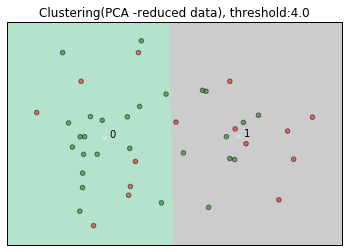

In [55]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_r[:, 0].min() - 1, X_r[:, 0].max() + 1
y_min, y_max = X_r[:, 1].min() - 1, X_r[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model
print best_k

kmeans = KMeans(init='k-means++', n_clusters=best_k, n_init=100)
kmeans.fit(X_r[:,:2])
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2,
           aspect='auto', origin='lower')


# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=16, linewidths=1,
            color='w', zorder=10, label="", alpha=0.5)

for k,c in enumerate(range(centroids.shape[0])):
    plt.text(centroids[k,0]+.2, centroids[k,1],str(k))

plt.scatter(X_r[:, 0], X_r[:, 1], c=np.array(["g" if d > thrs[-4] else "r" for d in df_all_scaled.ix[:,-1].values]), alpha=0.5)
plt.legend()
plt.title('Clustering(PCA -reduced data), threshold:' + str(thrs[-4]))

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

#### K-means explanation

CPAP USAGE (CLUST-0):
[0.0, 6.5, 5.0, 7.0, 5.0, 4.0, 4.5, 3.3199999999999998, 6.5, 6.5, 0.0, 4.9900000000000002, 2.0800000000000001, 5.3200000000000003, 2.6000000000000001, 4.0, 0.96999999999999997] 6 11 68.28
CPAP USAGE (CLUST-1):
[7.0, 7.5, 3.5, 6.5099999999999998, 6.0, 8.0, 5.5, 3.9300000000000002, 3.5, 7.0, 7.5, 4.0, 6.0, 7.5, 8.0, 7.0, 6.5, 4.5, 5.5, 7.0, 3.7999999999999998, 2.1200000000000001, 7.5, 4.0, 5.5] 5 20 144.86


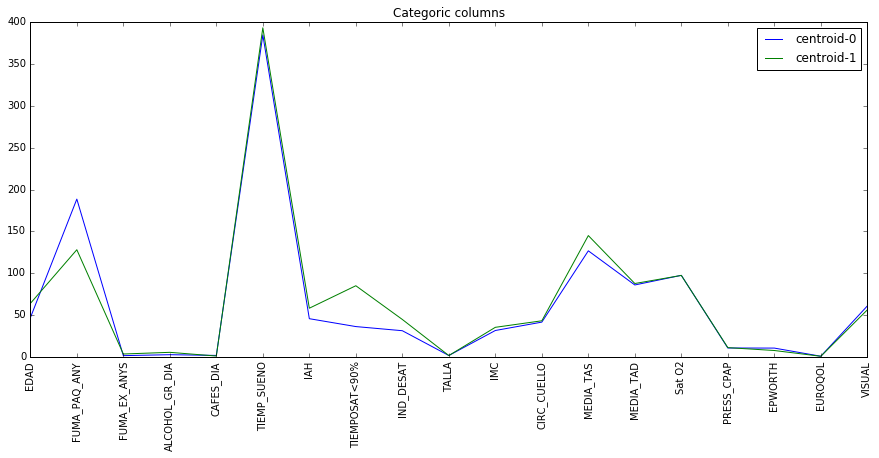

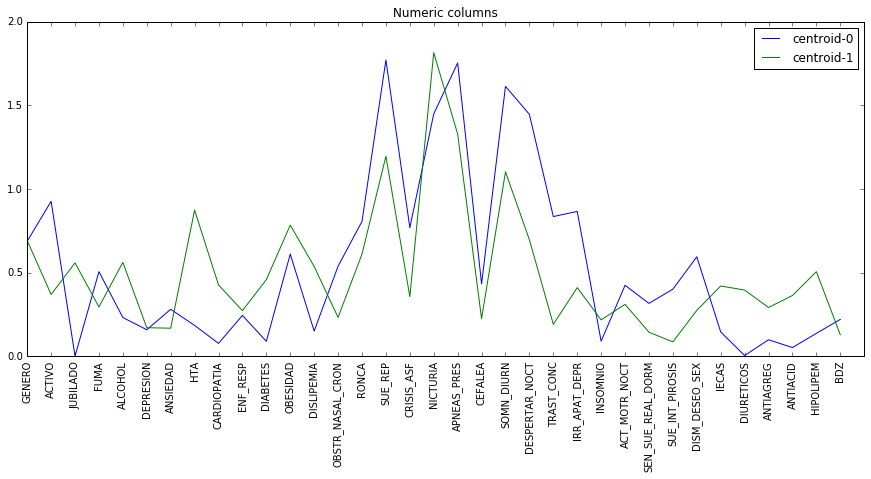

,0,1,diff[0-1]
GENERO,0.69,0.69,-0.00
ACTIVO,0.93,0.37,0.56
JUBILADO,0.00,0.56,-0.56
EDAD,46.73,63.87,-17.14
FUMA,0.51,0.30,0.21
FUMA_PAQ_ANY,188.56,128.06,60.50
FUMA_EX_ANYS,1.53,3.49,-1.96
ALCOHOL,0.23,0.56,-0.33
ALCOHOL_GR_DIA,2.68,5.48,-2.80
CAFES_DIA,1.80,1.06,0.74


In [53]:
X_pred = kmeans.predict(X_r[:,:2])
grAllRedKm = np.hstack((df_all_scaled.iloc[:,:-1],X_pred.reshape(-1,1)))

sleep = [[],[]]
for i,k in enumerate(X_pred):
    sleep[k].append(df_all.iloc[i,-1])
    
print "CPAP USAGE (CLUST-0):\n", sleep[0], np.sum(np.array(sleep[0]) < 4), np.sum(np.array(sleep[0]) >= 4), np.sum(sleep[0])
print "CPAP USAGE (CLUST-1):\n", sleep[1], np.sum(np.array(sleep[1]) < 4), np.sum(np.array(sleep[1]) >= 4), np.sum(sleep[1])
    
#Get pca for 2 components
pca = PCA(n_components=2)
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)

#Compute centroids
ctrPca = kmeans.cluster_centers_
ctrInvPca = [pca.inverse_transform(ctr.reshape(-1,2)) for ctr in ctrPca]
ctr = [scaler.inverse_transform(ctr) for ctr in ctrInvPca]
dfCtr = pd.DataFrame(np.array(ctr).reshape(2,-1), columns=df_all.columns[:-1])

for c in [0,1]:
    plt.figure(figsize=(15,6))
    ax = plt.subplot(1,1,1)

    for i in range(dfCtr.shape[0]):
        ax.plot(range(len(np.where(catCols==c)[0])), dfCtr.iloc[i,np.where(catCols==c)[0]],label="centroid-"+str(i), alpha=0.5)

    plt.xticks(range(len(np.where(catCols==c)[0])),dfCtr.columns[np.where(catCols==c)[0]],rotation=90)
    plt.title("Categoric columns" if c == 0 else "Numeric columns")
    plt.legend()
    plt.show()

diff = (dfCtr.iloc[0,:].values - dfCtr.iloc[1,:].values).reshape(1,-1)
ctr = np.hstack((dfCtr.T.values, diff.T))#, stats.ttest_ind(dfCtr.iloc[:,0], dfCtr.iloc[:,1])[1])
dfCtr = pd.DataFrame(ctr, columns= ["0","1","diff[0-1]"], index = dfCtr.T.index)
dfCtr

#### Outliers analysis

Looking for users with a value in its columns that is an outlier
We need user code!!

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


0.142667275157 11.6449371869 11.7876044621
12.0016053748 11.4309362742

Ouliers min ratio: 12.0016053748 11.4309362742
Num outliers detected: 1
Num outliers detected: 1
[('MY56', 11.886110231540361), ('MY12', 11.513430460459309), ('MY45', 11.579648528476202), ('MY55', 12.504549070237866), ('MY15', 11.499046367868486), ('MY20', 11.809233012098078), ('MY24', 11.959460383933498), ('MY28', 11.71072737500927), ('MY51', 11.712409936146093), ('MY09', 11.441740126420733), ('MY02', 11.719989047362073), ('MY59', 11.725468556002648), ('MY29', 11.896185573404175), ('MY21', 11.741851527464696), ('MY37', 11.678382899244028), ('MY34', 11.748281334923393), ('MY36', 11.701751925312674), ('MY27', 11.647403489808335), ('MY44', 11.789854301017639), ('MY14', 11.572564498832209), ('MY42', 11.700852430962819), ('MY41', 11.673432126741259), ('MY50', 11.948976602538336), ('MY18', 11.711252876220394), ('MY01', 11.669107206610109), ('MY57', 11.396781179819016), ('MY46', 11.506615602389385), ('MY06', 11.737770614

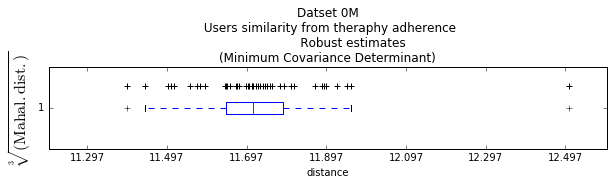

In [56]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

dfImputed_out = dfImputed.values
#dfImputed_out = df_all_scaled.ix[:,:-1]
scaler_norm = preprocessing.Normalizer(norm='l2').fit(dfImputed_out[:,:-1])
df_all_norm = scaler_norm.transform(dfImputed_out[:,:-1]).astype(float)

df_all_norm = pd.DataFrame(
    data = np.hstack((df_all_norm, dfImputed_out[:,-1].reshape((dfImputed_out.shape[0],1)))), 
    columns = df_all.columns[:-1])

X_SCALED = df_all_norm.ix[:,:-1].values
#X_SCALED = df_all.ix[:,:-1].values
#X_SCALED = df_all_scaled.ix[:,:-1].values

robust_cov_all = EmpiricalCovariance().fit(X_SCALED[:,:])
robust_mahal_all = robust_cov_all.mahalanobis(X_SCALED[:,:] - robust_cov_all.location_) ** (0.33)

#BoxPlot data
fig = plt.figure(figsize=(10,5))
sf = plt.subplot(3, 1, 1)
bx = sf.boxplot(robust_mahal_all,vert=0)

#ALT:1
#outlierRatioRob_all =  np.min(bx["fliers"][0].get_data()[0])

#ALT:2
rm = pd.DataFrame(robust_mahal_all, columns=["value"])

iqr = float(rm["value"].quantile(0.75)) - float(rm["value"].quantile(0.25))
outlierRatioRob_all_1 = rm["value"].quantile(0.75) + (1.5 * iqr)
outlierRatioRob_all_2 = rm["value"].quantile(0.25) - (1.5 * iqr)
print iqr, rm["value"].quantile(0.25), rm["value"].quantile(0.75)

#threshold = 0.99
#outlierRatioRob_all_1 = rm.quantile(threshold).values[0]
#outlierRatioRob_all_2 = rm.quantile(1-threshold).values[0]

print outlierRatioRob_all_1, outlierRatioRob_all_2
print

sf.plot(robust_mahal_all, 1.26 * np.ones(len(robust_mahal_all)),'+k', markeredgewidth=1)
sf.set_xlabel('distance')
sf.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
sf.set_title("Datset {}M\n Users similarity from theraphy adherence\n \
            Robust estimates\n(Minimum Covariance Determinant)".format(index))
sf.set_xticks(np.arange(min(robust_mahal_all)-0.1, max(robust_mahal_all)+0.1, 0.2))

print "Ouliers min ratio:", outlierRatioRob_all_1, outlierRatioRob_all_2
print "Num outliers detected:", len(X_SCALED[robust_mahal_all > outlierRatioRob_all_1, 0])
print "Num outliers detected:", len(X_SCALED[robust_mahal_all < outlierRatioRob_all_2, 0])
print [(codes[r],robust_mahal_all[r]) for r in range(len(robust_mahal_all))]

patients_out = codes[robust_mahal_all > outlierRatioRob_all_1]
print "Patients outliers above: {}".format(patients_out)

patients_out = codes[robust_mahal_all < outlierRatioRob_all_2]
print "Patients outliers below: {}".format(patients_out)


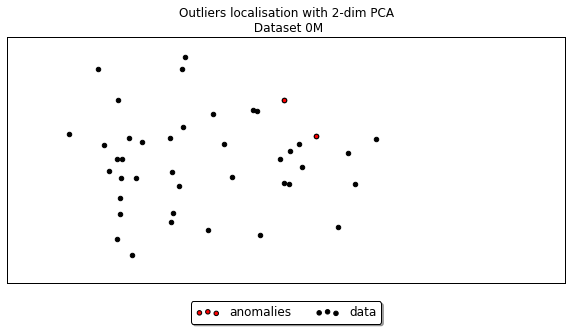

In [57]:
# plot and show data set
fig = plt.figure(figsize=(10,15))
subfig1 = plt.subplot(3, 1, 3)

#Show inliers vs outliers
inlier_plot = subfig1.scatter(X_r[:, 0], X_r[:, 1], c='black', label='inliers')
outlier_plot = subfig1.scatter(X_r[robust_mahal_all > outlierRatioRob_all_1, 0], 
                               X_r[robust_mahal_all > outlierRatioRob_all_1, 1],
                               c='red', label='outliers')
outlier_plot = subfig1.scatter(X_r[robust_mahal_all < outlierRatioRob_all_2, 0], 
                               X_r[robust_mahal_all < outlierRatioRob_all_2, 1],
                               c='red', label='outliers')

subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title(("Outliers localisation with 2-dim PCA\n Dataset {}M").format(index))

subfig1.legend([outlier_plot, inlier_plot],\
               ['anomalies','data'],\
               loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.xticks(())
plt.yticks(())

plt.show()

### Show all data

In [58]:
"""print df_all_scaled.shape
print df_all.iloc[:,-1].values.shape
print df_all.columns.shape

df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, df_all.iloc[:,-1].values.reshape(-1,1))),
    columns = df_all.columns)

print df_all_scaled.describe()"""

'print df_all_scaled.shape\nprint df_all.iloc[:,-1].values.shape\nprint df_all.columns.shape\n\ndf_all_scaled = pd.DataFrame(\n    data = np.hstack((df_all_scaled, df_all.iloc[:,-1].values.reshape(-1,1))),\n    columns = df_all.columns)\n\nprint df_all_scaled.describe()'

#### Visualize all data x columns

(27, 55)
(15, 55)


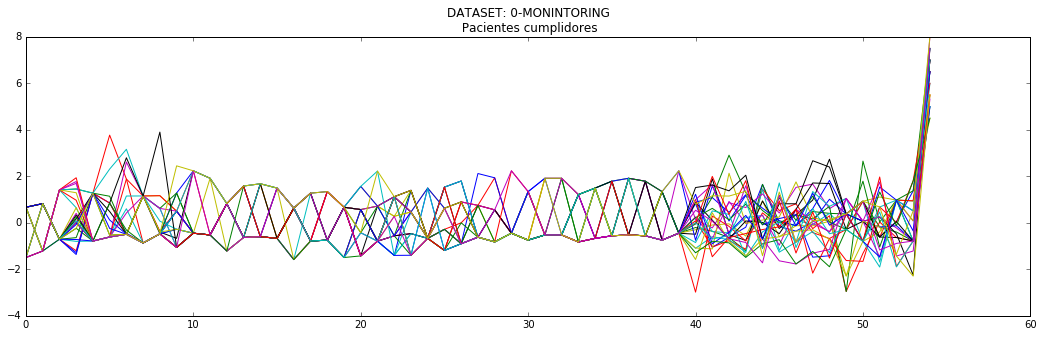

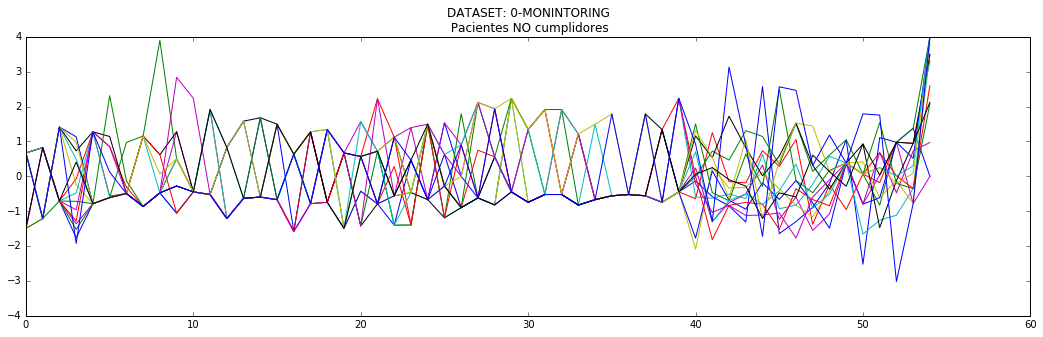

In [59]:
#Visualize row data

data = df_all_scaled[df_all_scaled['LABEL'] > thrs[-4]].values
data = data.astype(float)
print data.shape


plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

data = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values
data = data.astype(float)

print data.shape
plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

#### Visualize mean + std data

(27, 54)


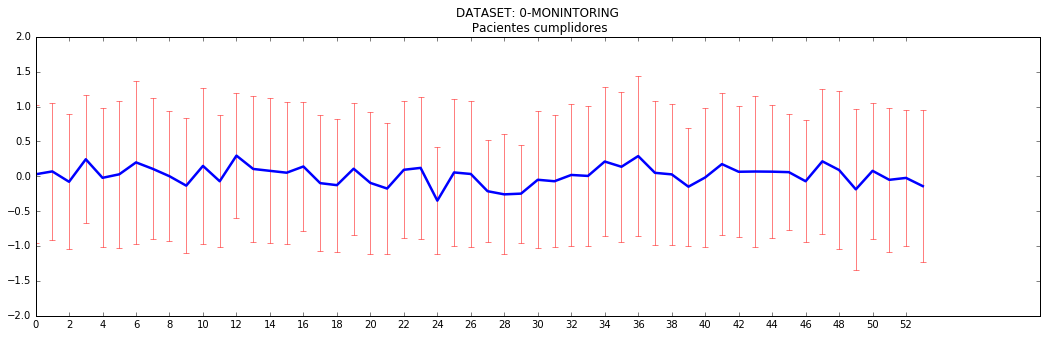

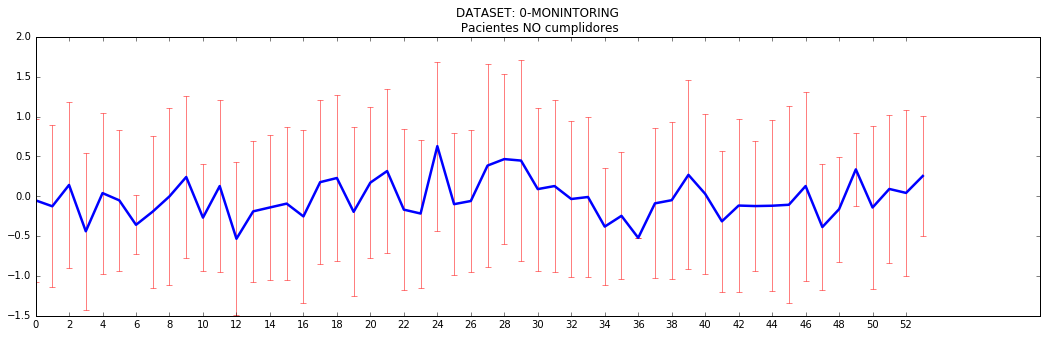

In [60]:
data_tmp = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)
print data.shape

plt.figure(figsize=(18,5))
plt.subplot(1,1,1)
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0), 
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
plt.ylim((-2,2))

data_tmp = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)

plt.figure(figsize=(18,5))
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0),
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

In [61]:
#NO cumplidores

df_all_scaled[df_all_scaled['LABEL']<=thrs[-4]][df_all_scaled.columns[:-1]]

,GENERO,ACTIVO,JUBILADO,EDAD,FUMA,FUMA_PAQ_ANY,FUMA_EX_ANYS,ALCOHOL,ALCOHOL_GR_DIA,CAFES_DIA,...,TALLA,IMC,CIRC_CUELLO,MEDIA_TAS,MEDIA_TAD,Sat O2,PRESS_CPAP,EPWORTH,EUROQOL,VISUAL
0,0.67,0.82,-0.71,-1.76,-0.78,-0.61,-0.49,-0.87,-0.48,-0.28,...,2.57,-1.64,-1.30,-0.89,-0.20,1.05,-2.52,1.11,0.98,1.38
6,0.67,0.82,-0.71,-0.72,-0.78,-0.61,0.97,1.15,3.90,0.50,...,1.14,0.34,1.52,0.14,0.61,1.05,0.07,-0.83,0.98,1.38
9,0.67,0.82,-0.71,-0.07,1.27,0.85,-0.31,-0.87,-0.48,0.50,...,0.73,0.28,1.05,-1.38,-0.24,-0.95,0.07,-0.18,0.98,0.94
11,0.67,-1.21,1.41,0.49,-0.78,-0.61,-0.49,1.15,-0.48,-1.06,...,0.63,-0.93,-0.83,-0.23,0.57,0.38,-1.66,-1.26,-1.12,-0.35
15,-1.49,0.82,-0.71,-1.36,-0.78,-0.61,-0.49,-0.87,-0.48,1.28,...,0.32,-1.23,-0.59,-1.55,-1.08,0.38,-0.80,0.03,0.98,-0.78
18,-1.49,-1.21,1.41,-0.24,-0.78,-0.61,-0.49,-0.87,-0.48,0.50,...,0.12,-0.36,-0.83,-1.16,-0.41,0.38,0.41,-0.61,-0.12,-0.78
19,0.67,-1.21,1.41,0.73,1.27,1.14,-0.49,1.15,0.62,1.28,...,0.02,0.57,1.52,0.31,-0.37,0.38,0.93,-1.47,-0.12,0.94
23,0.67,-1.21,1.41,1.13,-0.78,-0.61,-0.49,-0.87,-0.48,-1.06,...,-0.19,-0.66,-0.12,-0.77,-1.49,0.38,-0.80,-0.61,0.98,0.51
25,-1.49,-1.21,-0.71,-1.52,-0.78,2.31,-0.13,-0.87,-0.48,-0.28,...,-0.29,2.50,-0.12,-0.47,0.17,0.38,0.07,1.54,-0.20,-0.35
31,0.67,0.82,-0.71,-1.28,1.27,-0.57,-0.49,1.15,0.62,-1.06,...,-0.80,-1.52,-0.36,-0.67,-0.84,0.38,0.07,0.68,0.01,-0.35


In [62]:
target_names = ['No compliant', 'Compliant']
classLbls = ['No cumplidor', 'Cumplidor']
classes = [0,1]

(15, 54)
(27, 54)


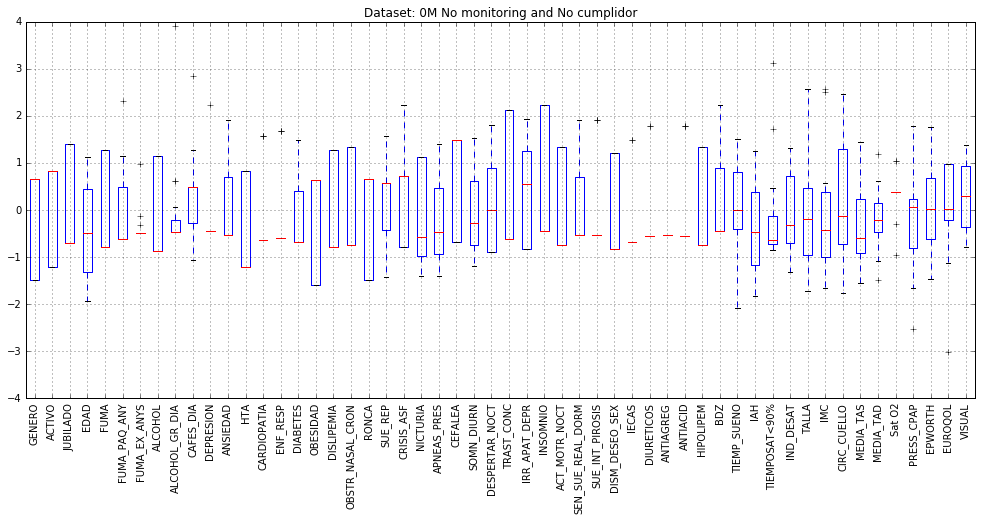

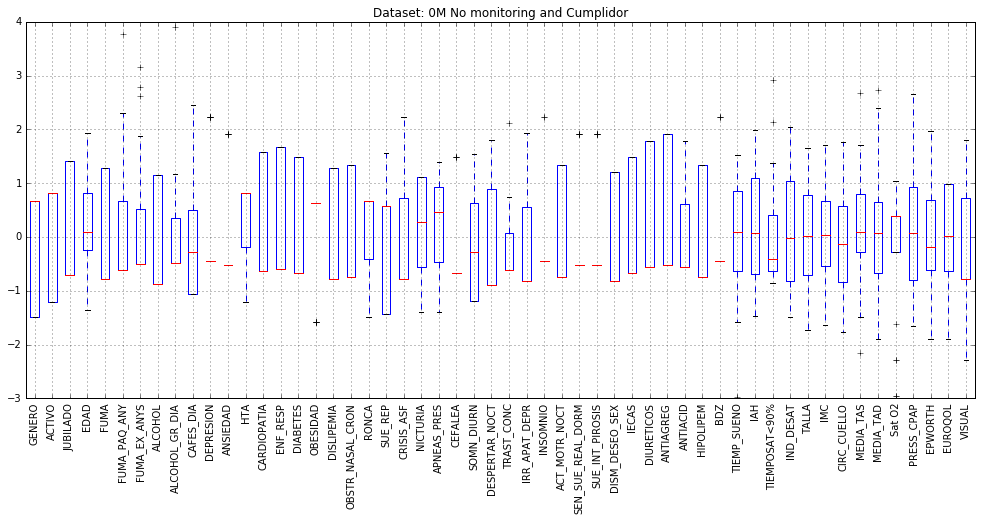

In [63]:
figsize = (17, 6.75)

codes_type = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[0]))

codes_type = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[1]))